### Projet de Computer Vison : **Estimation du Volume des Racines de Manioc à l'aide de la Vision par Ordinateur**

Membre de l'équipe:

- Membre 1: **Mbathe Mekontchou Paul**
- Membre 2: **Alexandre Desgrées du Loû**
- Membre 3: **VU Julien**


##### Notre sujet provient du challenge **Zindi**: **[Estimation du volume des racines du CGIAR](https://zindi.africa/competitions/cgiar-root-volume-estimation-challenge)**

Le manioc est une culture de base dans de nombreux pays africains. L'estimation précise du volume des racines est essentielle pour améliorer le rendement, optimiser la gestion des cultures et sélectionner des variétés résistantes aux conditions environnementales. Les méthodes traditionnelles d'estimation sont souvent **invasives et laborieuses**, d'où la nécessité de techniques non destructives.

Ce projet utilise des images issues d'un **radar à pénétration de sol (GPR)** pour estimer le volume des racines de manioc. Le jeu de données comprend des **scans multi-profondeurs** des racines de manioc, capturés depuis les côtés gauche et droit de la plante.

##### **Objectifs du projet**

- **Segmentation d'images** pour identifier et extraire les racines du manioc à partir des images GPR.
- **Estimation du volume des racines** à partir des images segmentées.
- **Optimisation des modèles** en utilisant des modèles de segmentation pré-entraînés (YOLO) ou des approches personnalisées.

##### **Méthodologie**

1. Traitement des images et sélection des couches optimales.
2. Segmentation des racines à l'aide de modèles d'apprentissage automatique.
3. Fusion des images gauche et droite pour estimer le volume total.
4. Évaluation des performances et amélioration du modèle.

Pour atteindre ces objectifs, nous avons utilisé plusieurs approches que nous allons détailler ci-dessous ainsi que les résultats obtenus.


### **Données et Structure des Fichiers**


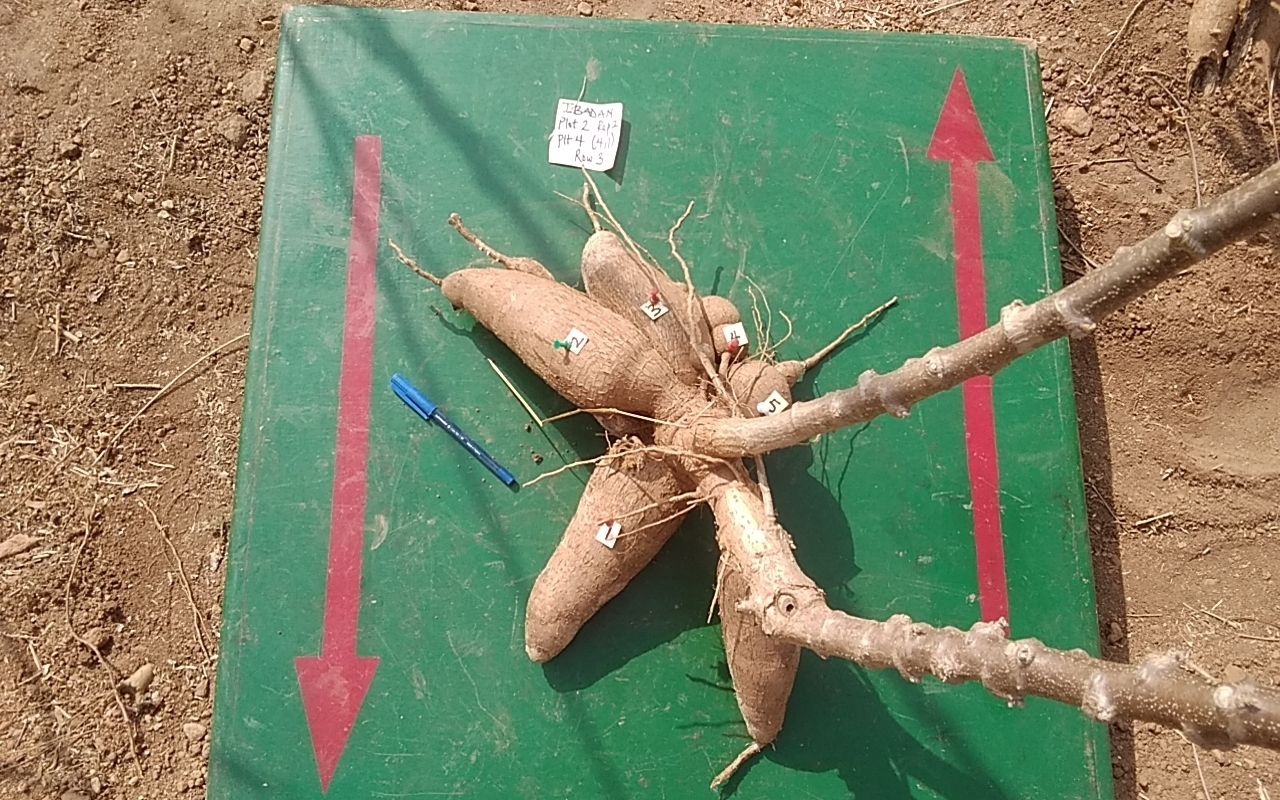


**Figure 1 : visualisation de la prise de donnée**


#### Images Radar

- **Format du fichier** : `XXXXXXXX_S_NNN.png`
  - `XXXXXXXX` : Identifiant aléatoire (nom du dossier contenant les images à différentes couches) exemple : Nto14cbfiw
  - `S` : Côté du scan (`L` pour gauche, `R` pour droit)
  - `NNN` : Numéro de couche (layer) du scan

#### Fichiers CSV

- **Train.csv et Test.csv** contiennent les informations sur chaque scan, notamment :
  - `FolderName` : Nom du dossier d'images (le `XXXXXXXX`)
  - `PlantNumber` : Numéro de la plante dans l'image (comptage de gauche à droite)
  - `Side` : Côté du scan (L ou R)
  - `Start` et `End` : Plage de couches suggérée pour la sélection d'images optimales (optionnelle)
  - `Genotype` et `Stage` : Informations sur le type de manioc et le stade de croissance (Early ou Late)
  - `RootVolume` : Volume cible à estimer (uniquement dans **Train.csv**)

#### Modèles de Segmentation

Trois modèles YOLO v11, ainsi que les annotations des images utilisées pour l'entraînement, nous ont été fournis dans le cadre du challenge et se trouvent dans le dossier. `Models` :

- `best_early.pt` : pour les données en stade précoce
- `best_late.pt` : pour les données en stade avancé
- `best_full.pt` : entraîné sur l’ensemble des données

En plus de ces trois modèles, nous avons également essayé de finetuner d'autres modèles, notamment une autre version de YOLO et Faster R-CNN sur ces points fournis. Vous trouverez également ces modèles dans le repertoire `Models` et `root_detection`


La **Figure 1** illustre de manière claire la méthode de génération des données.

- Les deux flèches indiquent le sens de déplacement du radar, qui se déplace à gauche et à droite des plantes.
- La caméra placée en hauteur montre que les images sont des vues _top-down_ (vue de dessus de la racine). Cela permet d'observer la racine à différents niveaux de profondeur.


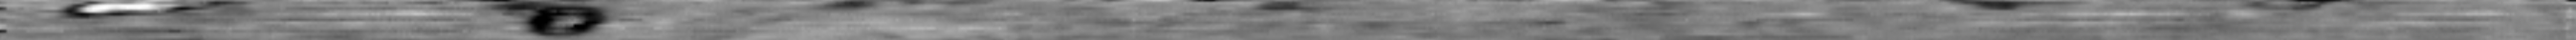


**Figure 2 : Exemple d'image Gauche couche 7 pour Nto14cbfiw**


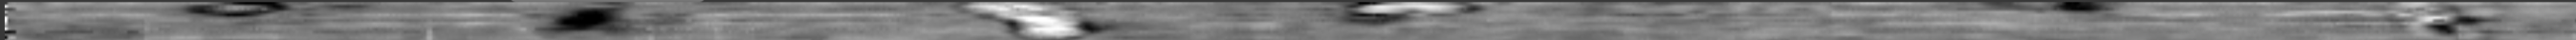


**Figure 3 : Exemple d'image Droite couche 7 pour Nto14cbfiw**


L'idée consiste à faire pivoter l'image de Droite de 180 degrés afin de la fusionner avec l'image de Gauche. Cette approche découle de l'analyse présentée dans la **Figure 1**. On obtient ainsi une seule et même image pour la couche 7 comme illustré **Figure 4**.


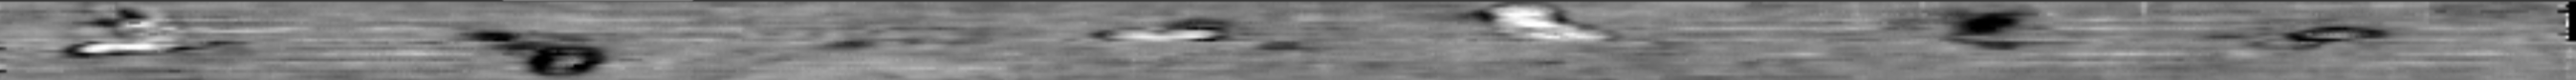


**Figure 4 : Image combinée Gauche et Droite**


Quelques éléments à considérer :

- **Nombre de plantes par image :**  
  Chaque image comporte au maximum 7 plantes visibles.

- **Visibilité des racines :**  
  Bien que chaque image soit conçue pour englober 7 plantes, certaines peuvent ne pas présenter de racines visibles depuis le radar. C'est pourquoi nous précisons que chaque image présente **au maximum** 7 plantes visibles.

- **Association plantes/racines :**  
  Plusieurs racines peuvent être associées à une même plante. Un des défis consistera donc à associer correctement les racines issues de la segmentation aux plantes correspondantes.


### **Prérequis**

Si vous souhaitez reproduire le code suivant, il est important d'exécuter les deux cellules ci-dessous pour installer les dépendances et télécharger les jeux de données, les modèles YOLO fournis pour le challenge ainsi que ceux que nous avons finetunés.


In [ ]:
### Installation des dépendances:

!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip3 install numpy
!pip3 install opencv-python
!pip3 install pandas
!pip3 install ultralytics
!pip3 install albumentations
!pip3 install matplotlib
!pip3 install gdown
!pip3 install albumentations
!pip3 install tqdm
!pip3 install tensorboard
!pip3 install lightgbm
!pip3 install seaborn matplotlib tensorflow tensorflow_docs scikit-learn statsmodels pats
!pip3 install segment-anything
!pip3 install xgboost
!{sys.executable} -m pip install opencv-python matplotlib ultralytics 'git+https://github.com/facebookresearch/segment-anything.git'

Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.2 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 33.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 38.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 37.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 28.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 38.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 34.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
# Importation des librairies
import torch
import numpy as np
import cv2
import os
from pathlib import Path
import pandas as pd
from typing import List, Tuple, Dict, Optional
from ultralytics import YOLO
import torch.nn as nn
import albumentations as A
from copy import deepcopy
from torchvision.models import  resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import warnings
import gdown
import zipfile
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from sklearn.metrics import r2_score
import pickle
from PIL import Image, ImageDraw, ImageFont
from glob import glob
import random
import shutil
from segment_anything import sam_model_registry, SamPredictor
warnings.filterwarnings("ignore")

In [ ]:
# Choix du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
DATASET_FILE_ID = "1pZnRV7VOS6y9qOHz3k9udwh7lYSeAq5E"
ROOT_FILE_ID = "1gIS-0HoNln5k0PP4SRn9QsL4tv6UZ3jH"
Models_FILE_ID = "1ZEG_l_05Ifw-B27H0uvEVHOSEKf742An"
FINETUNE_MODEL_ID ="129-qcdbHuHO7CkdOpngcX7yHElU-ijSH"


def download_dataset_from_drive(file_id, output_directory, file):
    """
    Télécharge un fichier ZIP depuis Google Drive et le décompresse.

    Args:
        file_id (str): L'ID du fichier Google Drive
        output_directory (str): Répertoire de destination pour le téléchargement et la décompression

    Returns:
        str: Chemin du fichier ZIP téléchargé
    """
    os.makedirs(output_directory, exist_ok=True)

    url = f'https://drive.google.com/uc?id={file_id}'

    output_zip = os.path.join(output_directory, f'{file}.zip')

    try:
        print(f"Téléchargement du fichier depuis : {url}")
        gdown.download(url, output_zip, quiet=False)

        print(f"Décompression du fichier dans : {output_directory}")
        with zipfile.ZipFile(output_zip, 'r') as zip_ref:
            zip_ref.extractall(output_directory)

        os.remove(output_zip)

        print("Téléchargement et décompression terminés avec succès.")
        return output_zip

    except Exception as e:
        print(f"Erreur lors du téléchargement ou de la décompression : {e}")
        return None


download_dataset_from_drive(DATASET_FILE_ID, "./", "data")
download_dataset_from_drive(ROOT_FILE_ID, "./", "root_detection")
download_dataset_from_drive(Models_FILE_ID, "./", "Models")
download_dataset_from_drive(FINETUNE_MODEL_ID, "./", "finetune_model")

Le dossier **finetune** contient deux notebook avec les codes utilisés pour finetuner Faster R-CNN et YOLO


# Approche I

#### **Sélection de la meilleure image en fonction de la profondeur pour la prédiction**

Cette approche permet d'optimiser la détection et l'estimation du volume des racines de manioc en sélectionnant les images les plus informatives et en combinant les données des côtés gauche et droit pour une analyse plus précise.


### 1.1 Sélection et Amélioration des Images de Racines de Manioc

La cellule ci dessous cherche à obtenir la meilleure image possible à partir d'un ensemble d'images prises à différentes profondeurs de la racine de manioc. Elle utilise plusieurs étapes pour améliorer la qualité de l'image, effectuer la détection des racines (plantes), et combiner les informations de plusieurs images prises sous différents angles (gauche et droite) :

1. **Sélection de la meilleure image en fonction de la profondeur** :  
   L'objectif de cette étape est de sélectionner l'image qui fournit les meilleures informations sur les racines de manioc, en se basant sur le nombre de racines détectées par le modèle YOLO. La méthode `find_best_layer_image` parcourt une plage de couches (de profondeur) et sélectionne l'image avec le plus grand nombre de détections, car cela est supposé indiquer la couche la plus informative pour la racine.

2. **Amélioration de la qualité de l'image** :  
   Une fois l'image choisie, elle est redimensionnée et normalisée pour correspondre aux exigences du modèle de réseau de neurones. Ce prétraitement est essentiel pour garantir que les images sont compatibles avec le modèle et présentent une qualité suffisante pour une détection optimale des racines.

3. **Segmentation des images de gauche et de droite** :  
   Les images des racines sont divisées en deux parties, représentant les côtés gauche et droit de la racine. Pour chaque côté, le modèle YOLO est utilisé pour détecter les racines et trier les détections en fonction de leur position sur l'image (de gauche à droite). Cela permet de mieux localiser chaque racine.

4. **Découpage de l'image en sections si aucune racine n'est détectée** :  
   Si aucune racine n'est trouvée dans l'image, celle-ci est découpée en sept sections égales. Ce découpage est utilisé pour garantir qu'une image de qualité suffisante sera toujours générée, même si la détection automatique échoue à localiser la plante dans l'image.

5. **Combinaison des images de gauche et de droite** :  
   Une fois les images de gauche et de droite préparées, elles sont combinées en une seule image avec 6 canaux (3 canaux pour chaque côté). Cette image combinée est ensuite utilisée comme entrée dans un réseau de neurones pour des prédictions plus précises du volume des racines.


In [ ]:

class CassavaRootDetector:
    def __init__(self, model_path: str = 'Models/best_full.pt'):
        self.model = YOLO(model_path, verbose=False)

    def load_image(self, folder_path: str, side: str, layer: int) -> Optional[np.ndarray]:
        pattern = f"*_{side}_{layer:03d}.png"
        image_paths = list(Path(folder_path).glob(pattern))
        if not image_paths:
            return None
        return cv2.imread(str(image_paths[0]))

    def find_best_layer_image(self, folder_path: str, side: str, start: int, end: int) -> Tuple[Optional[np.ndarray], int]:
        best_detections = 0
        best_image = None
        best_layer = None

        for layer in range(start, end + 1):
            img = self.load_image(folder_path, side, layer)
            if img is None:
                continue

            results = self.model.predict(img, conf=0.25, verbose=False)[0]
            num_detections = len(results.boxes)

            if num_detections > best_detections:
                best_detections = num_detections
                best_image = img
                best_layer = layer

        if best_image is None:
            median_layer = (start + end) // 2
            best_image = self.load_image(folder_path, side, median_layer)
            best_layer = median_layer

        return best_image, best_layer

    def detect_and_sort_plants(self, image: np.ndarray) -> List[Dict]:
        results = self.model.predict(image, conf=0.25, verbose=False)[0]
        detections = []

        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            detections.append({
                'bbox': [x1, y1, x2, y2],
                'confidence': conf,
                'center_x': (x1 + x2) / 2
            })

        detections.sort(key=lambda x: x['center_x'])
        return detections

    def prepare_combined_image(self, left_img: np.ndarray, right_img: np.ndarray, target_size=(224, 224)) -> np.ndarray:
        """
        Combine les images gauche et droite en un seul tableau pour le réseau de neurones
        """

        left_resized = cv2.resize(left_img, target_size)
        right_resized = cv2.resize(right_img, target_size)

        left_normalized = left_resized / 255.0
        right_normalized = right_resized / 255.0

        # Combiner les images (6 canaux: 3 pour gauche, 3 pour droite)
        combined = np.concatenate([left_normalized, right_normalized], axis=2)

        return combined

    def process_row(self, row: pd.Series, base_path: str, target_size=(224, 224)) -> Dict:
        folder_path = os.path.join(base_path, row['FolderName'])
        plant_number = row['PlantNumber'] - 1

        left_img, _ = self.find_best_layer_image(
            folder_path, 'L', row['Start'], row['End']
        )
        left_detections = self.detect_and_sort_plants(left_img)

        right_img, _ = self.find_best_layer_image(
            folder_path, 'R', row['Start'], row['End']
        )
        right_detections = self.detect_and_sort_plants(right_img)

        plant_images = []
        for side_img, detections in [(left_img, left_detections), (right_img, right_detections)]:
            if len(detections) > 0 and plant_number < len(detections):
                bbox = detections[plant_number]['bbox']
                x1, y1, x2, y2 = map(int, bbox)
                plant_crop = side_img[y1:y2, x1:x2]
            else:
                width = side_img.shape[1]
                section_width = width // 7
                x1 = section_width * plant_number
                x2 = x1 + section_width
                plant_crop = side_img[:, x1:x2]

            plant_images.append(plant_crop)

        combined_image = self.prepare_combined_image(
            plant_images[0], plant_images[1], target_size)

        return {
            'combined_image': combined_image,
            'root_volume': row['RootVolume'],
            'genotype': row['Genotype'],
            'stage': row['Stage']
        }


def prepare_dataset(df: pd.DataFrame, base_path: str, target_size=(224, 224)) -> Tuple[np.ndarray, np.ndarray]:
    """
    Prépare le dataset pour l'entraînement du réseau de neurones
    """
    detector = CassavaRootDetector()
    X = []
    y = []

    for idx, row in df.iterrows():
        try:
            result = detector.process_row(row, base_path, target_size)
            X.append(result['combined_image'])
            y.append(result['root_volume'])

            if (idx + 1) % 100 == 0:
                print(f"Traité {idx + 1} images")

        except Exception as e:
            print(f"Erreur lors du traitement de la ligne {idx}: {e}")
            continue

    return np.array(X), np.array(y)

### 1.2 Data Augmentation

La cellule ci-dessous implémente une approche d'augmentation de données pour améliorer la diversité du dataset utilisé pour entraîner le modèle. L'augmentation consiste à appliquer plusieurs transformations aux images d'origine, ce qui permet d'enrichir le dataset sans avoir à collecter de nouvelles données.

1. **Classe `DataAugmenter` :**

   - Cette classe utilise la bibliothèque **Albumentations** pour appliquer une série d'augmentations à des images. Les transformations incluent des ajustements de luminosité et contraste, l'ajout de bruit ou de flou, ainsi que des transformations géométriques légères comme le décalage, le redimensionnement, et la rotation.
   - Les augmentations sont appliquées séparément aux parties gauche et droite de l'image combinée, puis les images augmentées sont recombinées.

2. **Fonction `augment_dataset` :**

   - Cette fonction applique l'augmentation sur tout le dataset. Pour chaque image dans le dataset, plusieurs versions augmentées sont générées en fonction du nombre spécifié (par défaut 3).
   - L'image augmentée est ajoutée à la liste des images augmentées, et le volume de racine correspondant est aussi dupliqué.
   - Le DataFrame est également mis à jour avec des identifiants uniques pour chaque version augmentée de l'échantillon.

3. **Fonction `prepare_dataset_with_augmentation` :**
   - Cette fonction combine la préparation du dataset initial avec l'augmentation des données.
   - Elle retourne le dataset augmentée, incluant les images et les volumes de racines, ainsi que le DataFrame mis à jour avec les versions augmentées des données.


In [ ]:
class DataAugmenter:
    def __init__(self):
        self.augmentations = A.Compose([
            # Transformations de luminosité et contraste
            A.OneOf([
                A.RandomBrightnessContrast(
                    brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.RandomGamma(gamma_limit=(80, 120), p=0.5),
            ], p=0.5),

            # Bruit et flou - modification des paramètres pour assurer la compatibilité
            A.OneOf([
                A.GaussianBlur(blur_limit=(3, 5), p=0.5),
                A.MultiplicativeNoise(
                    multiplier=[0.95, 1.05], elementwise=True, p=0.5),
            ], p=0.3),

            # Transformations géométriques légères
            A.OneOf([
                A.ShiftScaleRotate(
                    shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.5),
                A.GridDistortion(distort_limit=0.1, p=0.5),
            ], p=0.3),
        ])

    def augment_sample(self, combined_image):
        """
        Applique les augmentations à une image combinée (gauche + droite)
        """
        if combined_image.dtype != np.uint8:
            combined_image = (combined_image * 255).astype(np.uint8)

        h, w, c = combined_image.shape
        left_img = combined_image[:, :, :3]
        right_img = combined_image[:, :, 3:]

        try:
            augmented_left = self.augmentations(image=left_img)
            left_aug = augmented_left['image']

            augmented_right = self.augmentations(image=right_img)
            right_aug = augmented_right['image']

            # Recombiner les images augmentées
            combined_aug = np.concatenate([left_aug, right_aug], axis=2)

            # Reconvertir en float32 si nécessaire
            if combined_image.dtype != np.uint8:
                combined_aug = combined_aug.astype(np.float32) / 255.0

            return combined_aug

        except Exception as e:
            print(f"Erreur lors de l'augmentation: {e}")
            return combined_image


def augment_dataset(df: pd.DataFrame, X: np.ndarray, y: np.ndarray, num_augmentations: int = 3):
    """
    Crée plusieurs versions augmentées du dataset

    Args:
        df: DataFrame original
        X: Images combinées originales
        y: Volumes des racines originaux
        num_augmentations: Nombre de versions augmentées à créer par échantillon

    Returns:
        X_augmented, y_augmented, df_augmented
    """
    augmenter = DataAugmenter()
    X_augmented = []
    y_augmented = []
    df_rows = []

    for idx in range(len(X)):
        # Ajouter l'échantillon original
        X_augmented.append(X[idx])
        y_augmented.append(y[idx])
        df_rows.append(df.iloc[idx])

        # Créer des versions augmentées
        for aug_idx in range(num_augmentations):
            try:
                aug_image = augmenter.augment_sample(X[idx])
                if aug_image is not None:
                    X_augmented.append(aug_image)
                    y_augmented.append(y[idx])

                    # Créer une nouvelle ligne dans le DataFrame avec un ID modifié
                    new_row = deepcopy(df.iloc[idx])
                    new_row['ID'] = f"{new_row['ID']}_aug{aug_idx+1}"
                    df_rows.append(new_row)
            except Exception as e:
                print(
                    f"Erreur lors de l'augmentation de l'échantillon {idx}: {e}")
                continue

    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)
    df_augmented = pd.concat([pd.DataFrame(df_rows)], ignore_index=True)

    return X_augmented, y_augmented, df_augmented


def prepare_dataset_with_augmentation(df: pd.DataFrame, base_path: str, target_size=(224, 224), num_augmentations=3,  prepare_dataset=prepare_dataset):
    X, y = prepare_dataset(df, base_path, target_size)

    X_augmented, y_augmented, df_augmented = augment_dataset(
        df, X, y, num_augmentations)

    return X_augmented, y_augmented, df_augmented

### 1.3 Normalization

La cellule ci-dessous implémente un processus de normalisation des images qui est essentiel pour préparer les données avant l'entraînement d'un modèle de deep learning. La normalisation améliore la convergence du modèle en ajustant les données à une échelle similaire.

1. **Classe `ImageNormalizer` :**

   - La classe `ImageNormalizer` calcule les statistiques nécessaires pour normaliser les images (moyenne et écart type par canal).
   - **Méthode `fit(X)`** : Calcule les moyennes et les écarts-types des images d'entraînement, utilisés pour normaliser les images lors de la phase d'entraînement. Elle s'assure également que les écarts-types n'atteignent pas zéro, ce qui pourrait entraîner une division par zéro lors de la normalisation.
   - **Méthode `transform_images(X)`** : Applique la normalisation sur un ensemble d'images en utilisant les statistiques calculées par `fit`. Cette méthode soustrait la moyenne de chaque canal et divise par l'écart type, ce qui standardise les valeurs des pixels de l'image.

2. **Fonction `prepare_normalized_data` :**
   - Cette fonction prépare les données en normalisant les images et en les convertissant en tenseurs PyTorch pour l'entraînement.
   - Si les données sont en phase d'entraînement (indiqué par `is_training=True`), elle ajuste le normaliseur aux données d'entrée (c'est-à-dire, elle calcule les statistiques de normalisation).
   - Elle applique ensuite la transformation de normalisation aux images d'entrée, avant de convertir les images normalisées et les volumes des racines (cibles) en tenseurs PyTorch. Ces tenseurs sont prêts à être utilisés dans un modèle.
   - Si un normaliseur a déjà été ajusté à des données précédentes (pour la phase de test, par exemple), il peut être passé en paramètre pour normaliser les images de test en utilisant les mêmes statistiques que celles utilisées pendant l'entraînement.


In [ ]:

class ImageNormalizer:
    def __init__(self):
        self.image_means = None
        self.image_stds = None

    def fit(self, X: np.ndarray):
        """
        Calcule les statistiques de normalisation sur les images d'entraînement

        Args:
            X: Images combinées (batch_size, height, width, channels)
        """
        # Calcul des stats par canal
        self.image_means = np.mean(X, axis=(0, 1, 2))
        self.image_stds = np.std(X, axis=(0, 1, 2))

        # Éviter la division par zéro
        self.image_stds = np.where(self.image_stds == 0, 1e-6, self.image_stds)

    def transform_images(self, X: np.ndarray) -> np.ndarray:
        """
        Normalise les images
        """
        if self.image_means is None or self.image_stds is None:
            raise ValueError("Normalizer must be fitted before transform")

        # Normalisation Z-score par canal
        X_normalized = (X - self.image_means) / self.image_stds
        return X_normalized


def prepare_normalized_data(
    X: np.ndarray,
    y: np.ndarray,
    normalizer: Optional[ImageNormalizer] = None,
    is_training: bool = True
) -> Tuple[torch.Tensor, torch.Tensor, ImageNormalizer]:
    """
    Prépare et normalise les données pour l'entraînement ou l'inférence

    Args:
        X: Images combinées (batch_size, height, width, channels)
        y: Volumes des racines (batch_size,)
        normalizer: Normalizer préexistant pour les données de test
        is_training: Si True, fit le normalizer sur les données

    Returns:
        X_tensor: Tenseur PyTorch des images normalisées
        y_tensor: Tenseur PyTorch des volumes (non normalisés)
        normalizer: Normalizer fitted
    """
    if normalizer is None:
        normalizer = ImageNormalizer()

    if is_training:
        normalizer.fit(X)

    # Normalisation des images uniquement
    X_normalized = normalizer.transform_images(X)

    # Conversion en tenseurs PyTorch
    X_tensor = torch.FloatTensor(X_normalized).permute(
        0, 3, 1, 2)  # (batch, channels, height, width)
    y_tensor = torch.FloatTensor(y)

    return X_tensor, y_tensor, normalizer

### 1.4 Définition du modèle

Nous avons essayé plusieurs architectures de modèles de deep learning appliquées à la vision par ordinateur pour cette tâche, mais celle qui nous a semblé la plus robuste et efficace est l'architecture présentée dans la cellule ci-dessous. Cette cellule définit un modèle de régression basé sur **ResNet18**, que nous avons adapté pour prédire le volume des racines de manioc à partir d'images. Elle comprend les étapes suivantes :

1. **Modèle `ResNetVolumePredictor`** :

   - Utilise un ResNet18 pré-entraîné, avec une modification de la première couche pour accepter des images à 6 canaux (gauche + droite).
   - Ajoute des couches personnalisées pour la régression afin de prédire le volume des racines de manioc.

2. **Fonction `train_model`** :

   - Entraîne le modèle avec des données d'entraînement et de validation.
   - Utilise un optimiseur **AdamW**, applique un mécanisme de **early stopping** et suit les métriques avec **TensorBoard**.

3. **Fonction `prepare_and_train_model`** :
   - Prépare les données en les augmentant, les normalise et les divise en ensembles d'entraînement et de validation.
   - Entraîne ensuite le modèle et retourne le modèle final ainsi que la meilleure perte de validation.


In [ ]:
class ResNetVolumePredictor(nn.Module):
    def __init__(self, normalizer: ImageNormalizer, freeze_backbone=True, dropout_rates=[0.5, 0.4, 0.3, 0.2], use_pretrained=True):
        super(ResNetVolumePredictor, self).__init__()
        self.normalizer = normalizer

        if use_pretrained:
            self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        else:
            self.resnet = resnet18(weights=None)

        original_layer = self.resnet.conv1
        self.resnet.conv1 = nn.Conv2d(
            6, 64,
            kernel_size=original_layer.kernel_size,
            stride=original_layer.stride,
            padding=original_layer.padding,
            bias=original_layer.bias is not None
        )

        if use_pretrained:
            with torch.no_grad():
                self.resnet.conv1.weight[:, :3] = original_layer.weight
                self.resnet.conv1.weight[:, 3:] = original_layer.weight * 0.5

        if freeze_backbone:
            for param in self.resnet.parameters():
                param.requires_grad = False

            self.resnet.conv1.weight.requires_grad = True
            for name, param in self.resnet.named_parameters():
                if "layer4" in name or "layer3" in name:
                    param.requires_grad = True

        num_features = self.resnet.fc.in_features

        self.resnet.fc = nn.Identity()

        feature_sizes = [512, 256, 128, 64]
        layers = []
        input_size = num_features

        for i, size in enumerate(feature_sizes):
            layers.extend([
                nn.Linear(input_size, size),
                nn.BatchNorm1d(size),
                nn.LeakyReLU(0.1),
                nn.Dropout(dropout_rates[i])
            ])
            input_size = size

        layers.append(nn.Linear(feature_sizes[-1], 1))

        self.regression_head = nn.Sequential(*layers)

        self.pre_conv = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1, groups=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, 6, kernel_size=3, padding=1),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(0.1)
        )

        self.skip_alpha = nn.Parameter(torch.tensor(0.2))

        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(6, 6, kernel_size=1),
            nn.Sigmoid()
        )

        self.input_norm = nn.BatchNorm2d(6)

        self.activation_regularizer = nn.Sequential(
            nn.Dropout2d(0.1),
            nn.GroupNorm(2, 6)
        )

    def forward(self, x):
        x = self.input_norm(x)

        x_preprocessed = self.pre_conv(x)
        attention = self.channel_attention(x_preprocessed)
        x_preprocessed = x_preprocessed * attention

        x = x_preprocessed + self.skip_alpha * x

        x = self.activation_regularizer(x)

        features = self.resnet(x)

        volume = self.regression_head(features)

        return volume

    def predict_volume(self, x: torch.Tensor) -> np.ndarray:
        self.eval()
        with torch.no_grad():
            return self(x).cpu().numpy()


    def configure_optimizer(self, lr=1e-4, weight_decay=1e-5):
        backbone_params = []
        head_params = []

        for name, param in self.named_parameters():
            if 'resnet' in name:
                backbone_params.append(param)
            else:
                head_params.append(param)

        optimizer = torch.optim.AdamW([
            {'params': backbone_params, 'lr': lr *
                0.1, 'weight_decay': weight_decay},
            {'params': head_params, 'lr': lr, 'weight_decay': weight_decay * 2}
        ])

        return optimizer


class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, predicted, target):
        mse_loss = self.mse(predicted, target)
        rmse_loss = torch.sqrt(mse_loss + self.eps)

        return rmse_loss

Le code de la cellule ci-dessous permet de lancer l'entrainement du modèle et afficher l'évolutions des erreurs d'apprentissage


In [ ]:
def train_model_with_jupyter_viz(
    model: ResNetVolumePredictor,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    num_epochs: int = 5,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    log_dir: str = 'runs/experiment',
    lr=2e-4,
    weight_decay=2e-5
):

    current_time = datetime.now().strftime('%b%d_%H-%M-%S')
    log_dir = os.path.join(log_dir, current_time)
    writer = SummaryWriter(log_dir)
    model_save_dir = os.path.join(log_dir, 'models')
    os.makedirs(model_save_dir, exist_ok=True)

    optimizer = model.configure_optimizer(lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    criterion = RMSELoss()
    mae_criterion = RMSELoss()

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    metrics_history = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'val_r2': [],
        'val_mae': [],
        'learning_rate': []
    }
    model = model.to(device)

    for epoch in range(num_epochs):

        model.train()
        train_loss = 0
        batch_count = 0

        for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            batch_count += 1

            # Logging des métriques par batch
            if batch_idx % 10 == 0:
                writer.add_scalar('Loss/train_batch', loss.item(),
                                  epoch * len(train_loader) + batch_idx)

        model.eval()
        val_loss = 0
        val_mae = 0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y.unsqueeze(1)).item()
                val_mae += mae_criterion(outputs, batch_y.unsqueeze(1)).item()

                val_preds.extend(outputs.cpu().numpy().flatten())
                val_targets.extend(batch_y.cpu().numpy())

        train_loss /= batch_count
        val_loss /= len(val_loader)
        val_mae /= len(val_loader)
        val_r2 = r2_score(val_targets, val_preds)

        metrics_history['epoch'].append(epoch + 1)
        metrics_history['train_loss'].append(train_loss)
        metrics_history['val_loss'].append(val_loss)
        metrics_history['val_r2'].append(val_r2)
        metrics_history['val_mae'].append(val_mae)
        metrics_history['learning_rate'].append(
            optimizer.param_groups[0]['lr'])

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/validation', val_loss, epoch)
        writer.add_scalar('MAE/validation', val_mae, epoch)
        writer.add_scalar('R2/validation', val_r2, epoch)
        writer.add_scalar(
            'Learning_rate', optimizer.param_groups[0]['lr'], epoch)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(
            f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val R²: {val_r2:.4f}')

        scheduler.step(val_loss)

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_r2': val_r2,
        }
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(checkpoint, os.path.join(
                model_save_dir, 'best_model.pth'))
            print(
                f"Meilleur modèle sauvegardé avec perte de validation: {val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping déclenché à l'époque {epoch+1}")
                break

    writer.close()

    metrics_df = pd.DataFrame(metrics_history)

    best_checkpoint = torch.load(
        os.path.join(model_save_dir, 'best_model.pth'))
    model.load_state_dict(best_checkpoint['model_state_dict'])

    print(
        f"Entraînement terminé. Les logs TensorBoard sont disponibles dans: {log_dir}")

    return model, best_val_loss, metrics_df, log_dir


def visualize_training_in_notebook(metrics_df, log_dir=None, plots=None):
    """
    Affiche les courbes d'apprentissage dans le notebook de façon fiable.

    Args:
        metrics_df: DataFrame contenant les métriques d'entraînement
        log_dir: Répertoire des logs TensorBoard (optionnel)
        plots: Liste des types de graphiques à afficher ['loss', 'r2', 'mae', 'lr']
    """
    import matplotlib.pyplot as plt

    # Si aucun plot n'est spécifié, utiliser tous les plots disponibles
    if plots is None:
        plots = ['loss', 'r2', 'mae', 'lr']

    for plot_type in plots:
        plt.figure(figsize=(6, 4))

        if plot_type == 'loss':
            plt.plot(metrics_df['epoch'],
                     metrics_df['train_loss'], 'b-', label='Train')
            plt.plot(metrics_df['epoch'],
                     metrics_df['val_loss'], 'r-', label='Validation')
            plt.xlabel('Époque')
            plt.ylabel('Perte (MSE)')
            plt.title('Courbes d\'apprentissage')
            plt.legend()
            plt.grid(True)

        elif plot_type == 'r2':
            plt.plot(metrics_df['epoch'], metrics_df['val_r2'], 'g-')
            plt.xlabel('Époque')
            plt.ylabel('R²')
            plt.title('Évolution du R²')
            plt.grid(True)

        elif plot_type == 'mae':
            plt.plot(metrics_df['epoch'], metrics_df['val_mae'], 'm-')
            plt.xlabel('Époque')
            plt.ylabel('MAE')
            plt.title('Évolution de l\'erreur absolue moyenne')
            plt.grid(True)

        elif plot_type == 'lr':
            plt.plot(metrics_df['epoch'], metrics_df['learning_rate'], 'k-')
            plt.xlabel('Époque')
            plt.ylabel('Taux d\'apprentissage')
            plt.title('Évolution du taux d\'apprentissage')
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    if log_dir:
        try:
            from tensorboard import notebook
            return notebook.list()
        except ImportError:
            return None

    return None


def prepare_and_train_model_with_viz(df: pd.DataFrame, base_path: str, batch_size: int = 32, num_epochs: int = 25,
                                     Model_classe=ResNetVolumePredictor, prepare_dataset=prepare_dataset,  lr=2e-4, weight_decay=2e-5):
    """
    Fonction complète qui prépare les données, entraîne le modèle et affiche les visualisations
    dans le notebook Jupyter.
    """
    print("Préparation et augmentation des données...")
    X_augmented, y_augmented, df_augmented = prepare_dataset_with_augmentation(
        df, base_path, target_size=(224, 224), num_augmentations=3, prepare_dataset=prepare_dataset
    )

    print("Normalisation des données...")
    X_tensor, y_tensor, normalizer = prepare_normalized_data(
        X_augmented, y_augmented)

    print(f"Création du modèle {Model_classe.__name__}...")
    model = Model_classe(normalizer)

    dataset_size = len(X_tensor)
    train_size = int(0.8 * dataset_size)
    indices = torch.randperm(dataset_size)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_dataset = torch.utils.data.TensorDataset(
        X_tensor[train_indices], y_tensor[train_indices]
    )
    val_dataset = torch.utils.data.TensorDataset(
        X_tensor[val_indices], y_tensor[val_indices]
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size
    )

    print(
        f"Entraînement du modèle avec {train_size} échantillons d'entraînement et {dataset_size - train_size} échantillons de validation...")
    model, best_val_loss, metrics_df, log_dir = train_model_with_jupyter_viz(
        model, train_loader, val_loader, num_epochs=num_epochs, lr=lr, weight_decay=weight_decay
    )

    tb_viz = visualize_training_in_notebook(
        metrics_df, log_dir, plots=['loss', 'r2', 'mae',])

    return model, normalizer, best_val_loss, tb_viz

#### Explication détaillée de l'architecture du modèle

L'architecture du modèle **ResNetVolumePredictor** est composée de plusieurs parties essentielles:

1. **Prétraitement avec couches convolutionnelles supplémentaires (`pre_conv`)** :

   - Cette partie prépare les images avant qu'elles ne soient envoyées dans le réseau ResNet.
   - Trois couches convolutionnelles sont utilisées pour transformer les images, suivi de normalisation par lot et activation ReLU. L'idée est d'ajouter une couche de traitement initiale afin de mieux adapter les images à la structure de ResNet.
   - **Raison** : Étant donné que les images ont 6 canaux (3 pour l'image gauche et 3 pour l'image droite), ces couches supplémentaires aident à capter des caractéristiques pertinentes à partir des deux perspectives avant de les introduire dans le ResNet.

2. **ResNet18** :

   - **ResNet18** est utilisé comme un modèle de base. C'est un réseau de neurones convolutifs profond qui a l'avantage de gérer efficacement la dégradation du réseau grâce à ses **connexions résiduelles**. Ces connexions permettent au modèle de mieux apprendre des couches profondes sans souffrir du problème de gradient qui disparaît.
   - **Raison** : ResNet18 est un modèle largement éprouvé dans la reconnaissance d'images. Utiliser un modèle pré-entraîné permet d'exploiter des représentations de haute qualité apprises sur un grand dataset (ImageNet), ce qui accélère la convergence du modèle et améliore ses performances.

3. **Modification de la première couche du ResNet** :

   - La première couche de **ResNet18** est modifiée pour accepter des images à **6 canaux** au lieu de 3. Les 3 premiers canaux sont pour l'image gauche et les 3 suivants pour l'image droite.
   - **Raison** : Cette modification est nécessaire pour que le modèle puisse traiter des images en double perspective, ce qui est crucial pour l'estimation du volume des racines.

4. **Partie régression (`regression_head`)** :

   - Après l'extraction des caractéristiques via ResNet18, une **tête de régression** est ajoutée. Elle se compose de plusieurs couches fully connected (linéaires), suivies de **BatchNorm**, **ReLU**, et **Dropout**.
   - Cette partie du modèle est conçue pour effectuer la régression sur les caractéristiques extraites par ResNet afin de prédire un seul nombre : le volume de la racine de manioc.
   - **Raison** : Les couches fully connected permettent au modèle d'apprendre des relations complexes entre les caractéristiques extraites et le volume cible. Le **Dropout** est utilisé pour éviter le sur-apprentissage (overfitting) pendant l'entraînement, et **BatchNorm** aide à stabiliser l'apprentissage.

5. **Loss et optimisation** :

   - La perte utilisée est la **RMSELoss** (Root Mean Square Error), tel que exigé par le challenge.
   - **AdamW** est utilisé comme optimiseur, et un **scheduler** de réduction du taux d'apprentissage est appliqué pour ajuster dynamiquement le taux d'apprentissage en fonction de la performance sur les données de validation.

6. **Early stopping** :
   - Le modèle utilise un mécanisme d'**early stopping** pour arrêter l'entraînement si la perte de validation ne s'améliore pas après un certain nombre d'époques.
   - **Raison** : Cette technique permet de prévenir l'overfitting en arrêtant l'entraînement dès que le modèle cesse de s'améliorer sur les données de validation.

#### Raisons du choix de cette architecture

1. **Utilisation de ResNet18** : La raison principale pour utiliser ResNet18 est qu'il est déjà bien optimisé pour l'extraction de caractéristiques complexes, ce qui est essentiel dans des tâches de vision par ordinateur où les données sont visuellement complexes. De plus, son architecture avec des connexions résiduelles est idéale pour éviter les problèmes liés à la profondeur du réseau et pour améliorer la performance.

2. **Modifications adaptées aux images à 6 canaux** : L'adaptation de ResNet18 pour traiter des images avec 6 canaux (et non 3) répond directement à la nature spécifique du problème : il s'agit d'images prises de deux perspectives (gauche et droite) de la même racine de manioc.

3. **Régression à travers des couches fully connected** : Après avoir extrait les caractéristiques à partir de ResNet, les couches fully connected permettent d'effectuer la régression pour prédire un volume.

4. **Optimisation et régularisation efficaces** : L'utilisation de **AdamW** et de **BatchNorm** garantit un apprentissage stable, rapide et efficace, tout en intégrant une régularisation pour éviter l'overfitting. Le **scheduler** de taux d'apprentissage permet de s'adapter pendant l'entraînement pour améliorer la convergence.


Préparation et augmentation des données...
Traité 100 images
Traité 200 images
Traité 300 images
Normalisation des données...
Création du modèle ResNetVolumePredictor...
Entraînement du modèle avec 1235 échantillons d'entraînement et 309 échantillons de validation...
Epoch 1/50:
Train Loss: 2.4262, Val Loss: 2.2635, Val R²: -1.4848
Meilleur modèle sauvegardé avec perte de validation: 2.2635
Epoch 2/50:
Train Loss: 2.2322, Val Loss: 2.1501, Val R²: -1.2456
Meilleur modèle sauvegardé avec perte de validation: 2.1501
Epoch 3/50:
Train Loss: 2.0621, Val Loss: 1.9836, Val R²: -0.9101
Meilleur modèle sauvegardé avec perte de validation: 1.9836
Epoch 4/50:
Train Loss: 1.8840, Val Loss: 1.9198, Val R²: -0.8053
Meilleur modèle sauvegardé avec perte de validation: 1.9198
Epoch 5/50:
Train Loss: 1.7589, Val Loss: 1.7615, Val R²: -0.5171
Meilleur modèle sauvegardé avec perte de validation: 1.7615
Epoch 6/50:
Train Loss: 1.6876, Val Loss: 1.6694, Val R²: -0.3609
Meilleur modèle sauvegardé avec pert

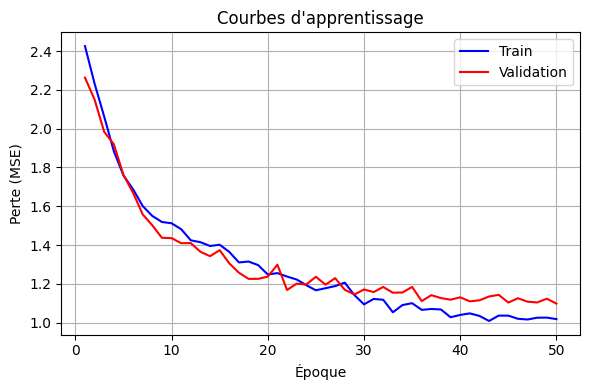

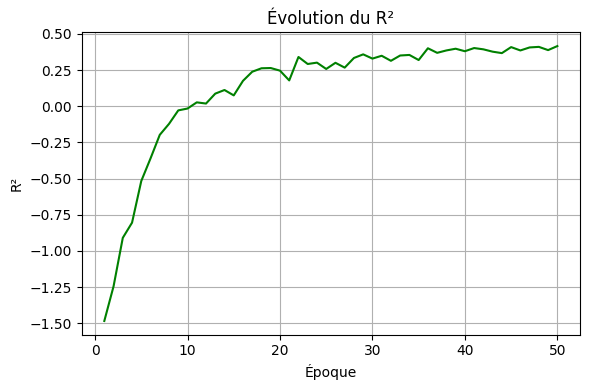

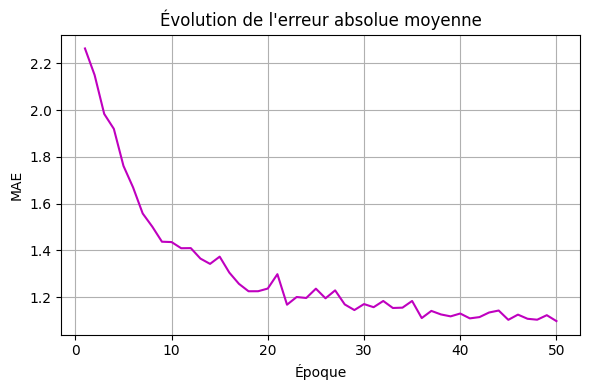

No known TensorBoard instances running.


In [ ]:
# Préparation et entraînement
df = pd.read_csv('./data/Train.csv')
base_path = "./data/train"
model, normalizer, best_val_loss, tb_viz = prepare_and_train_model_with_viz(
    df, base_path, batch_size=32, lr=2.5e-4, weight_decay=2.5e-4, num_epochs=50)

#### Analyse des résultats d'entraînement du modèle

1. **Réduction de la perte**

- La perte d'entraînement diminue régulièrement, passant de **2.4262** à **1.0181**.
- La perte de validation suit la même tendance, passant de **2.2635** à **1.0979**.

2. **Amélioration du R²**

- Initialement négatif (**-1.4848**), indiquant que le modèle était pire qu'une simple moyenne.
- Il progresse jusqu'à **0.4154**, montrant une meilleure capacité à expliquer la variance des données.

3. **Stagnation et fluctuations**

- À partir de l'époque **20-25**, la perte de validation varie légèrement, suggérant un possible plateau.
- Quelques fluctuations de R² après l'époque **30**, mais la tendance reste à l'amélioration.

4. **Meilleurs résultats enregistrés**

- Le meilleur modèle est atteint à l'époque **50** avec :
  - **Perte de validation : 1.0979**
  - **R² : 0.4154**

Dans l'ensemble, le modèle devient de plus en plus performant. Nous avons essayé d'améliorer ces performances en jouant sur les valeurs des hyperparamètres, mais nous n'avons pas obtenu de meilleurs résultats. De même, l'utilisation des modèles YOLO finetunés par nos soins n'a pas permis d'améliorer considérablement les résultats avec cette approche. Les courbes ci-dessous montrent l'évoltution des la perte en train et en test sur les deux approches.

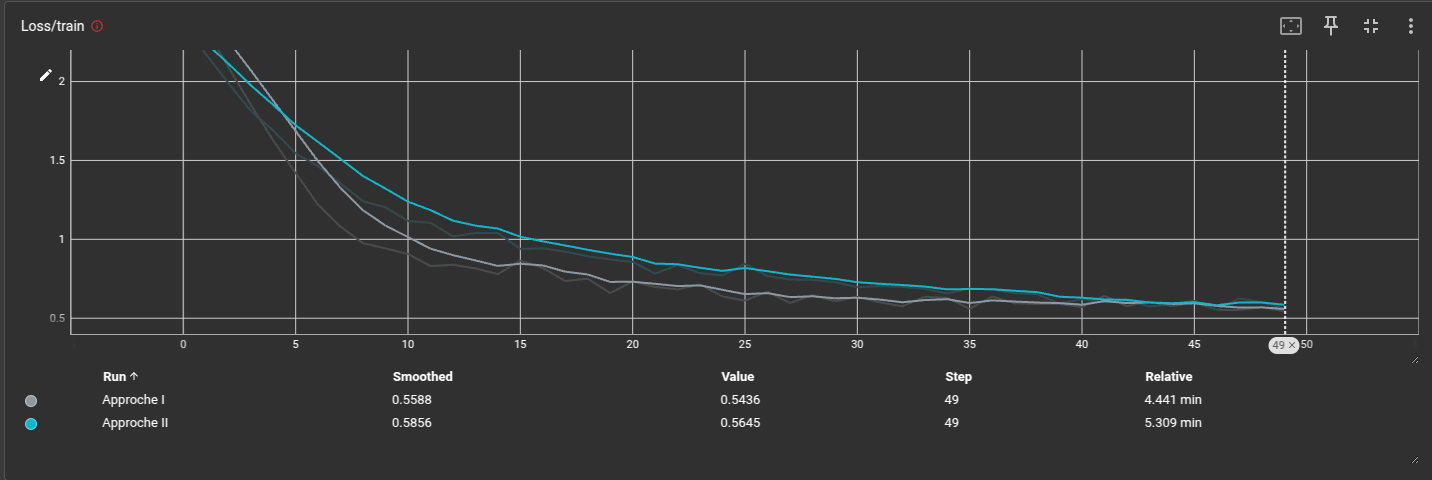

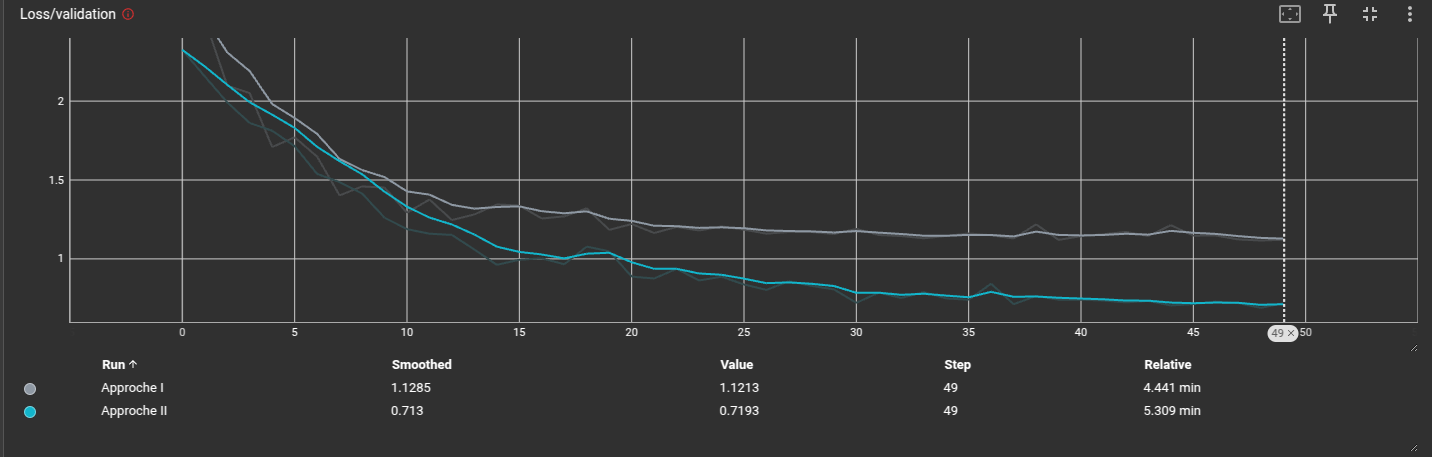


In [ ]:
test_df = pd.read_csv('./data/Test.csv')
test_df["RootVolume"] = pd.Series([0 for x in range(len(test_df.index))])
base_path = r"./data/test"
X_test_data, y_test_data = prepare_dataset(test_df, base_path)
X_test_data_tensor = torch.FloatTensor(X_test_data).permute(0, 3, 1, 2)
X_normalized = model.normalizer.transform_images(X_test_data)
X_tensor = torch.FloatTensor(X_normalized).permute(0, 3, 1, 2)
predicts = [float(model.predict_volume(x.unsqueeze(0).to("cuda")).item())
            for x in X_tensor]
result = pd.DataFrame({"ID": test_df["ID"], "RootVolume": predicts})
result.to_csv("./submission/file_submission_02_03_14_58.csv", index=False)

Traité 100 images


### Évaluation en test

Les données de test fournies par **Zindi** pour l'évaluation de notre modèle ne sont pas annotées. La seule façon de vérifier si notre modèle a de bonnes performances est de soumettre le fichier de prédiction sur Zindi et d'obtenir l'erreur fournie. L'image ci-dessous présente les résultats obtenus après avoir soumis les résultats de l'exécution du modèle.


Résultat obtenu après soumission sur Zindi
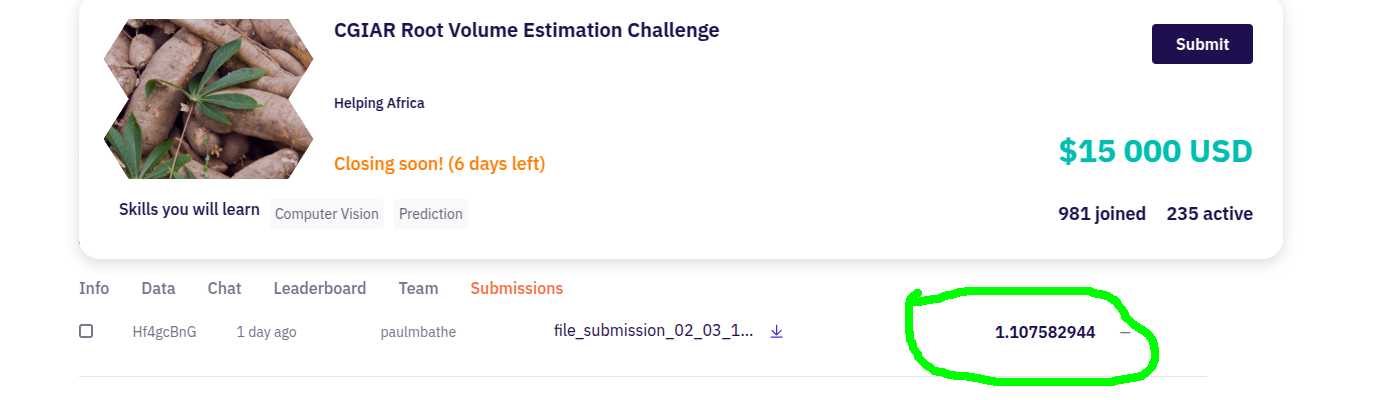


### Analyse des Résultats

Nous constatons que le modèle est **très robuste à l'overfitting**, car le **meilleur résultat** obtenu sur le jeu de données de validation (**1.0979**) est **proche de celui obtenu sur le jeu de test soumis à Zindi**. Cela indique une bonne généralisation du modèle aux données non vues.

Cependant, malgré plusieurs variations des **hyperparamètres**, nous n'avons pas réussi à **améliorer significativement les performances de prédiction** avec l'approche décrite précédemment.

Nous estimons donc que l'une des **meilleures alternatives** pour améliorer les performances du modèle **réside dans la manière dont nous regroupons les images**. Plutôt que de sélectionner uniquement la **meilleure image**, nous proposons une nouvelle approche où nous **regroupons les images selon différents niveaux de profondeur**. Cette méthode pourrait permettre de mieux capturer la structure des racines et ainsi améliorer la précision des prédictions.


## Approche II

Dans cette approche, nous explorons une méthode alternative pour traiter les images de racines de manioc. L'objectif est de segmenter, fusionner les images afin d'optimiser l'analyse et la sélection des régions pertinentes pour l'estimation du volume des racines.


#### Étapes principales :

1. **Segmentation en régions verticales** (`draw_vertical_lines`) :

   - Dans cette approche, nous ajoutons des lignes verticales pour diviser l’image en plusieurs régions distinctes.
   - Chaque région est numérotée pour faciliter l’identification des segments pertinents.

2. **Fusion des images gauche et droite** (`merge_left_right`) :

   - Nous combinons les images issues des vues gauche et droite en une seule image fusionnée.
   - Cette fusion permet d’obtenir une représentation plus complète de la racine sous différents angles.

3. **Empilement des images** (`stack_images_vertically`) :

   - Ici, assemblons plusieurs images fusionnées en une seule image verticale.
   - Cela permet d'avoir des racines sur plusieurs couches successives.

4. **Découpage d'une image en sous-parties** (`split_image_into_arrays`) :
   - Dans cette approche, nous divisons une image en plusieurs segments égaux sous forme de tableaux numpy.
   - Cette segmentation permet d’analyser chaque partie indépendamment et d’optimiser le traitement.

L'objectif global de cette approche est de fournir une méthode pour groupper et segmenter pour analyser les images des racines. En divisant et combinant les images de différentes manières, nous améliorons la sélection des régions d'intérêt et optimisons les performances du modèle d'estimation du volume.


In [ ]:
def draw_vertical_lines(image, n, line_color=(255, 0, 0), line_width=1, font_size=40):
    draw = ImageDraw.Draw(image)
    width, height = image.size

    try:
        font = ImageFont.truetype(
            "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", font_size)  # Common WSL font
    except IOError:
        font = ImageFont.load_default()

    step = width / n
    number_colors = [(0, 0, 255), (0, 255, 0), (255, 165, 0),
                     (128, 0, 128), (0, 255, 255)]  # Example colors

    for i in range(1, n):  # Exclude the first and last edges
        x = int(i * step)
        draw.line([(x, 0), (x, height)], fill=line_color, width=line_width)

    for i in range(n):
        num_x = int((i + 0.5) * step)
        num_y = height // 2
        num_color = random.choice(number_colors)
        text = str(i + 1)

        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        draw.text((num_x - text_width // 2, num_y - text_height // 2),
                  text, fill=num_color, font=font)

    return image


def merge_left_right(limg, rimg):

    width = min(limg.width, rimg.width)
    _, height = limg.size
    limg = limg.crop((0, 0, width, height))
    _, height = rimg.size
    rimg = rimg.crop((0, 0, width, height))

    stacked_img = Image.new("RGB", (width, limg.height + rimg.height))

    stacked_img.paste(rimg.rotate(180), (0, 0))
    stacked_img.paste(limg, (0, rimg.height))

    return stacked_img


def stack_images_vertically(images):

    min_width = min(img.width for img in images)
    images = [img.crop((0, 0, min_width, img.height)) for img in images]

    total_height = sum(img.height for img in images)

    stacked_img = Image.new("RGB", (min_width, total_height))

    y_offset = 0
    for img in images:
        stacked_img.paste(img, (0, y_offset))
        y_offset += img.height

    return stacked_img


def see_all_plants(fname, type="train", s=8, e=61):
    limgs = sorted(glob(f'./data/{type}/{fname}/{fname}_L_*.png'))
    rimgs = sorted(glob(f'./data/{type}/{fname}/{fname}_R_*.png'))

    lims = [Image.open(i) for i in limgs][s:e]
    rims = [Image.open(i) for i in rimgs][s:e]

    ims = []
    for l, r in zip(lims, rims):
        i = merge_left_right(l, r)
        ims.append(i)

    return stack_images_vertically(ims)


def split_image_into_arrays(image, n):
    """
    Divise une image en n parties égales et renvoie une liste de tableaux numpy.

    Args:
        image: Une image PIL
        n: Nombre de divisions souhaitées

    Returns:
        Une liste de n tableaux numpy représentant chaque partie de l'image
    """
    if not isinstance(image, np.ndarray):
        img_array = np.array(image)
    else:
        img_array = image

    width = img_array.shape[1]

    part_width = width // n

    image_parts = []

    for i in range(n):
        start_col = i * part_width
        end_col = (i + 1) * part_width if i < n - 1 else width

        part = img_array[:, start_col:end_col].copy()
        image_parts.append(part)

    return image_parts

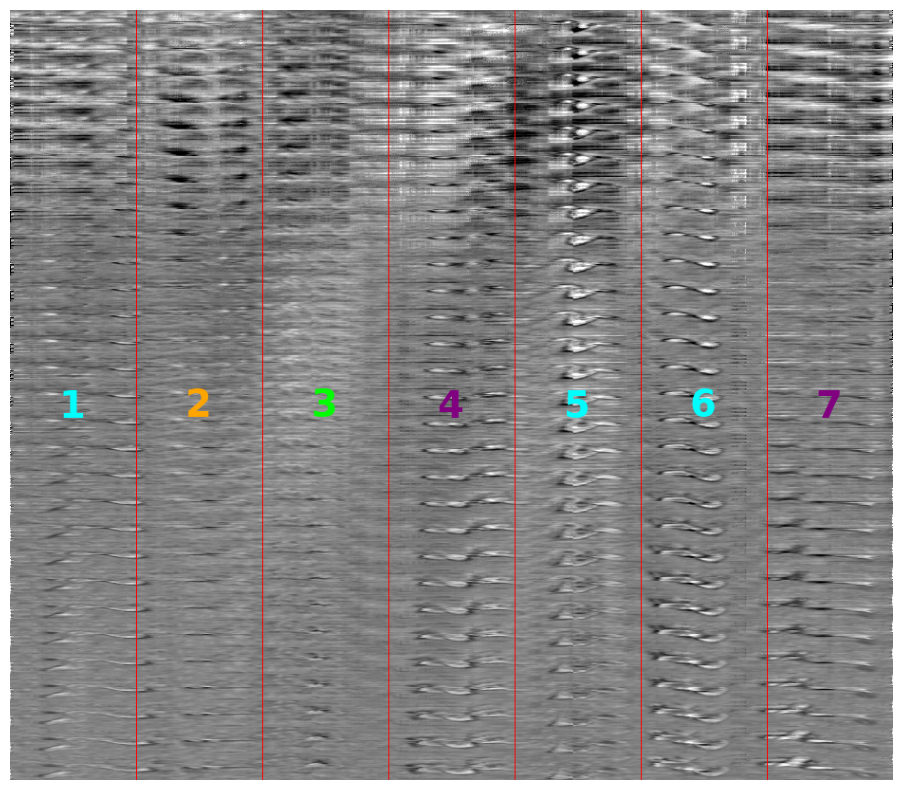

In [ ]:
# L'image ci-dessous illustre les plantes 1 à 30 de l'échantillon d'un dossier pour que vous puissiez voir comment elles sont divisées en parties
folder = 'Yvlyjpumzl'
img = see_all_plants(folder, type="test", s=1, e=30)
img = draw_vertical_lines(img, n=7)
plt.figure(figsize=(30, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
def prepare_dataset_phase_2(df: pd.DataFrame, base_path: str, target_size=(224, 224), type_data="train") -> Tuple[List, np.ndarray]:
    """
    Prépare le dataset pour l'entraînement du réseau de neurones
    """
    X = []
    y = []

    for idx, row in df.iterrows():
        try:
            folder = row['FolderName']
            img = see_all_plants(folder, type=type_data,
                                 s=row["Start"], e=row["End"])
            imgs = split_image_into_arrays(img, n=7)
            plant_img = imgs[row['PlantNumber']-1]
            resized_img = cv2.resize(plant_img, target_size)

            X.append(resized_img)
            y.append(row['RootVolume'])

            if (idx + 1) % 100 == 0:
                print(f"Traité {idx + 1} images")

        except Exception as e:
            print(row['FolderName'])
            print(f"Erreur lors du traitement de la ligne {idx}: {e}")
            continue

    y_array = np.array(y)
    X_array = np.array(X)

    return X_array, y_array

Dans les cellules ci-dessous, nous héritons du modèle précédent en l'adaptant pour traiter les images en 3 canaux au lieu de 6. Ensuite, nous adaptons un certain nombre de méthodes et classes précédentes pour les faire correspondre avec la nouvelle logique des données.


In [ ]:
class ResNetVolumePredictor3Channel(ResNetVolumePredictor):
    def __init__(self, normalizer, freeze_backbone=True, dropout_rates=[0.5, 0.4, 0.3, 0.2], use_pretrained=True):
        super(ResNetVolumePredictor3Channel, self).__init__(
            normalizer=normalizer)
        self.normalizer = normalizer

        if use_pretrained:
            self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        else:
            self.resnet = resnet18(weights=None)

        if freeze_backbone:
            for param in self.resnet.parameters():
                param.requires_grad = False

            self.resnet.conv1.weight.requires_grad = True
            for name, param in self.resnet.named_parameters():
                if "layer4" in name or "layer3" in name:
                    param.requires_grad = True

        num_features = self.resnet.fc.in_features

        self.resnet.fc = nn.Identity()

        feature_sizes = [512, 256, 128, 64]
        layers = []
        input_size = num_features

        for i, size in enumerate(feature_sizes):
            layers.extend([
                nn.Linear(input_size, size),
                nn.BatchNorm1d(size),
                nn.LeakyReLU(0.1),
                nn.Dropout(dropout_rates[i])
            ])
            input_size = size

        layers.append(nn.Linear(feature_sizes[-1], 1))

        self.regression_head = nn.Sequential(*layers)
        self.pre_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1, groups=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.1)
        )

        self.skip_alpha = nn.Parameter(torch.tensor(0.2))

        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(3, 3, kernel_size=1),
            nn.Sigmoid()
        )

        self.input_norm = nn.BatchNorm2d(3)

        self.activation_regularizer = nn.Sequential(
            nn.Dropout2d(0.1),
            nn.GroupNorm(1, 3)
        )

    def forward(self, x):
        x = self.input_norm(x)

        x_preprocessed = self.pre_conv(x)
        attention = self.channel_attention(x_preprocessed)
        x_preprocessed = x_preprocessed * attention

        x = x_preprocessed + self.skip_alpha * x

        x = self.activation_regularizer(x)

        features = self.resnet(x)

        volume = self.regression_head(features)

        return volume

    def predict_volume(self, x: torch.Tensor) -> np.ndarray:
        self.eval()
        with torch.no_grad():
            return self(x).cpu().numpy()

    def configure_optimizer(self, lr=1e-4, weight_decay=1e-5):

        backbone_params = []
        head_params = []

        for name, param in self.named_parameters():
            if 'resnet' in name:
                backbone_params.append(param)
            else:
                head_params.append(param)

        optimizer = torch.optim.AdamW([
            {'params': backbone_params, 'lr': lr *
                0.1, 'weight_decay': weight_decay},
            {'params': head_params, 'lr': lr, 'weight_decay': weight_decay * 2}
        ])

        return optimizer

In [ ]:
class DataAugmenter:
    def __init__(self):
        self.augmentations = A.Compose([

            A.OneOf([
                A.RandomBrightnessContrast(
                    brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.RandomGamma(gamma_limit=(80, 120), p=0.5),
            ], p=0.5),

            A.OneOf([
                A.GaussianBlur(blur_limit=(3, 5), p=0.5),
                A.MultiplicativeNoise(
                    multiplier=[0.95, 1.05], elementwise=True, p=0.5),
            ], p=0.3),


            A.OneOf([
                A.ShiftScaleRotate(
                    shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.5),
                A.GridDistortion(distort_limit=0.1, p=0.5),
            ], p=0.3),
        ])

    def augment_sample(self, combined_image):
        """
        Applique les augmentations à une image combinée (gauche + droite)
        """
        if combined_image.dtype != np.uint8:
            combined_image = (combined_image * 255).astype(np.uint8)

        left_img = combined_image[:, :, :3]

        try:
            augmented_left = self.augmentations(image=left_img)
            left_aug = augmented_left['image']

            combined_aug = left_aug

            if combined_image.dtype != np.uint8:
                combined_aug = combined_aug.astype(np.float32) / 255.0

            return combined_aug

        except Exception as e:
            print(f"Erreur lors de l'augmentation: {e}")
            return combined_image

Préparation et augmentation des données...
Traité 100 images
Traité 200 images
Traité 300 images
Normalisation des données...
Création du modèle ResNetVolumePredictor3Channel...
Entraînement du modèle avec 1235 échantillons d'entraînement et 309 échantillons de validation...
Epoch 1/50:
Train Loss: 2.3589, Val Loss: 2.3247, Val R²: -1.5391
Meilleur modèle sauvegardé avec perte de validation: 2.3247
Epoch 2/50:
Train Loss: 2.1750, Val Loss: 2.1567, Val R²: -1.2006
Meilleur modèle sauvegardé avec perte de validation: 2.1567
Epoch 3/50:
Train Loss: 1.9906, Val Loss: 1.9918, Val R²: -0.8837
Meilleur modèle sauvegardé avec perte de validation: 1.9918
Epoch 4/50:
Train Loss: 1.8144, Val Loss: 1.8613, Val R²: -0.6446
Meilleur modèle sauvegardé avec perte de validation: 1.8613
Epoch 5/50:
Train Loss: 1.6901, Val Loss: 1.8121, Val R²: -0.5671
Meilleur modèle sauvegardé avec perte de validation: 1.8121
Epoch 6/50:
Train Loss: 1.5438, Val Loss: 1.7139, Val R²: -0.4135
Meilleur modèle sauvegardé a

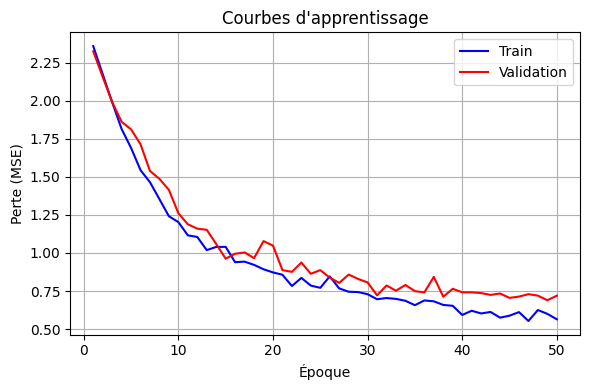

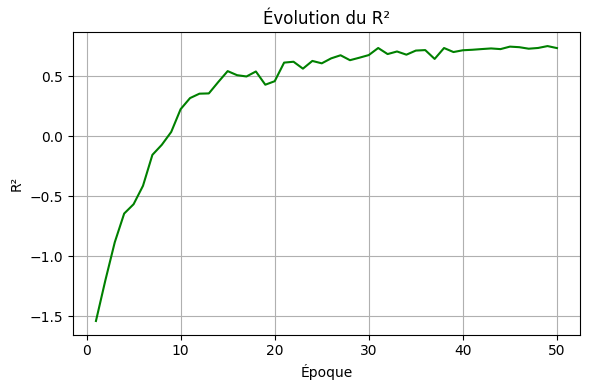

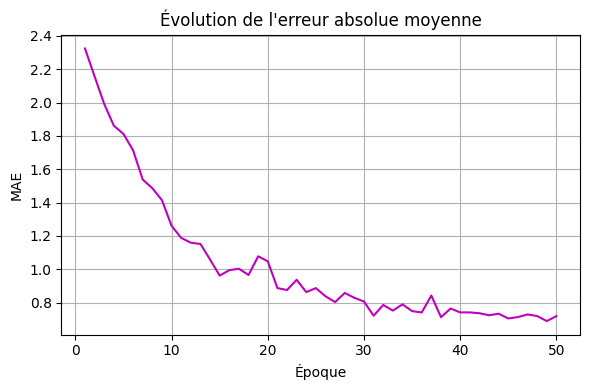

No known TensorBoard instances running.


In [ ]:
df = pd.read_csv('./data/Train.csv')
base_path = "./data/train"
model, normalizer, best_val_loss, tb_viz = prepare_and_train_model_with_viz(
    df, base_path, batch_size=32, num_epochs=50, lr=2.5e-4, weight_decay=2.5e-4, Model_classe=ResNetVolumePredictor3Channel, prepare_dataset=prepare_dataset_phase_2)

#### **Analyse comparative de l'approche II par rapport à l'approche I**

Dans cette approche, nous avons introduit une méthode basée sur le prétraitement des images pour grouper, puis segmenter et sélectionner des régions pertinentes. Comparons son impact sur les résultats obtenus précédemment.

##### - **Préparation et augmentation des données**

L'approche précédente traitait directement un ensemble d'images sans segmentation détaillée, tandis que l'approche II segmente et fusionne les images, ce qui permet une meilleure organisation des données d'entrée

##### - **Normalisation et entraînement**

Durant l'entraînement du modèle **ResNetVolumePredictor3Channel** on observe une évolution stable des pertes d'entraînement et de validation, avec une forte baisse de la valeur de la perte en validation, atteignant **0.6893** contre **1.0979** pour l'approche I. Cela démontre que cette approche est nettement meilleure que la précédente.

##### - **Impact de l'approche II**

L'approche II améliorer la stabilité et la robustesse du modèle en fournissant des images mieux segmentées et alignées :

- **Meilleure distinction des régions pertinentes**, réduisant le bruit dans les images d’entrée.
- **Fusion plus cohérente des images gauche/droite**, offrant une représentation plus homogène.
- **Segmentation en sous-parties**, facilitant une analyse plus fine par le modèle.


In [ ]:
test_df = pd.read_csv('./data/Test.csv')
test_df["RootVolume"] = pd.Series([0 for x in range(len(test_df.index))])
base_path = r"/home/paul/Cours/computer_vision/data/test"
X_test_data, y_test_data = prepare_dataset_phase_2(
    test_df, base_path, type_data="test")
X_test_data_tensor = torch.FloatTensor(X_test_data).permute(0, 3, 1, 2)
X_normalized = model.normalizer.transform_images(X_test_data)
X_tensor = torch.FloatTensor(X_normalized).permute(0, 3, 1, 2)
predicts = [float(model.predict_volume(x.unsqueeze(0).to("cuda")).item())
            for x in X_tensor]
result = pd.DataFrame({"ID": test_df["ID"], "RootVolume": predicts})
result.to_csv("./submission/file_submission_02_03_16_26.csv", index=False)

Traité 100 images


L'image ci-dessous est le résultat obtenu après la soumission du modèle sur Zindi, ce qui montre une nette amélioration du modèle par rapport à l'approche précédente.

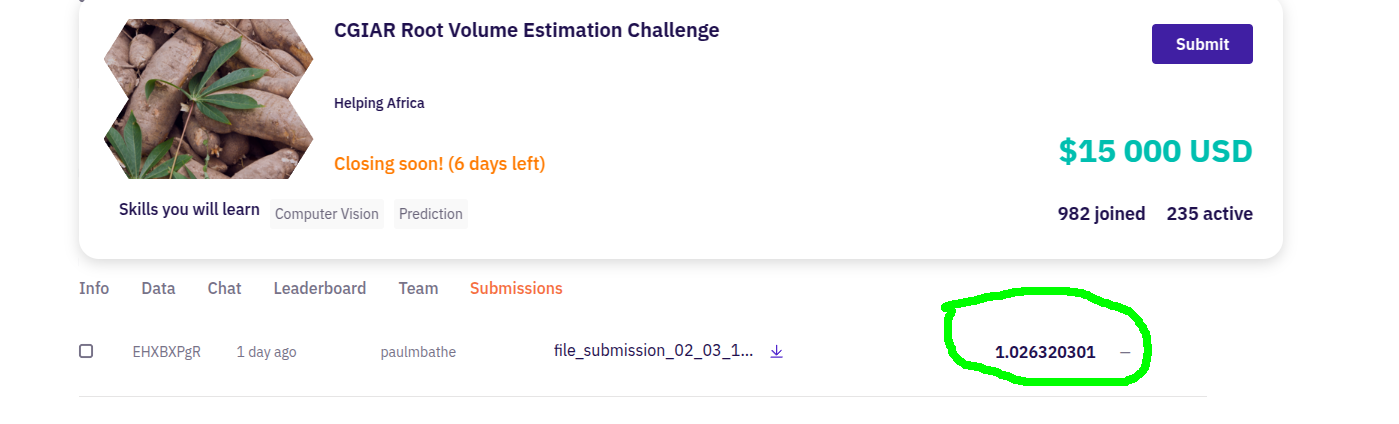


## Approche III


Ce pipeline intègre plusieurs modèles pour générer les données d'entraînement finales. L'objectif est de tirer parti des atouts de chacun afin d'améliorer la segmentation. Une double segmentation, d'abord via YOLO puis via SAM, permettra d'affiner la détection des racines.


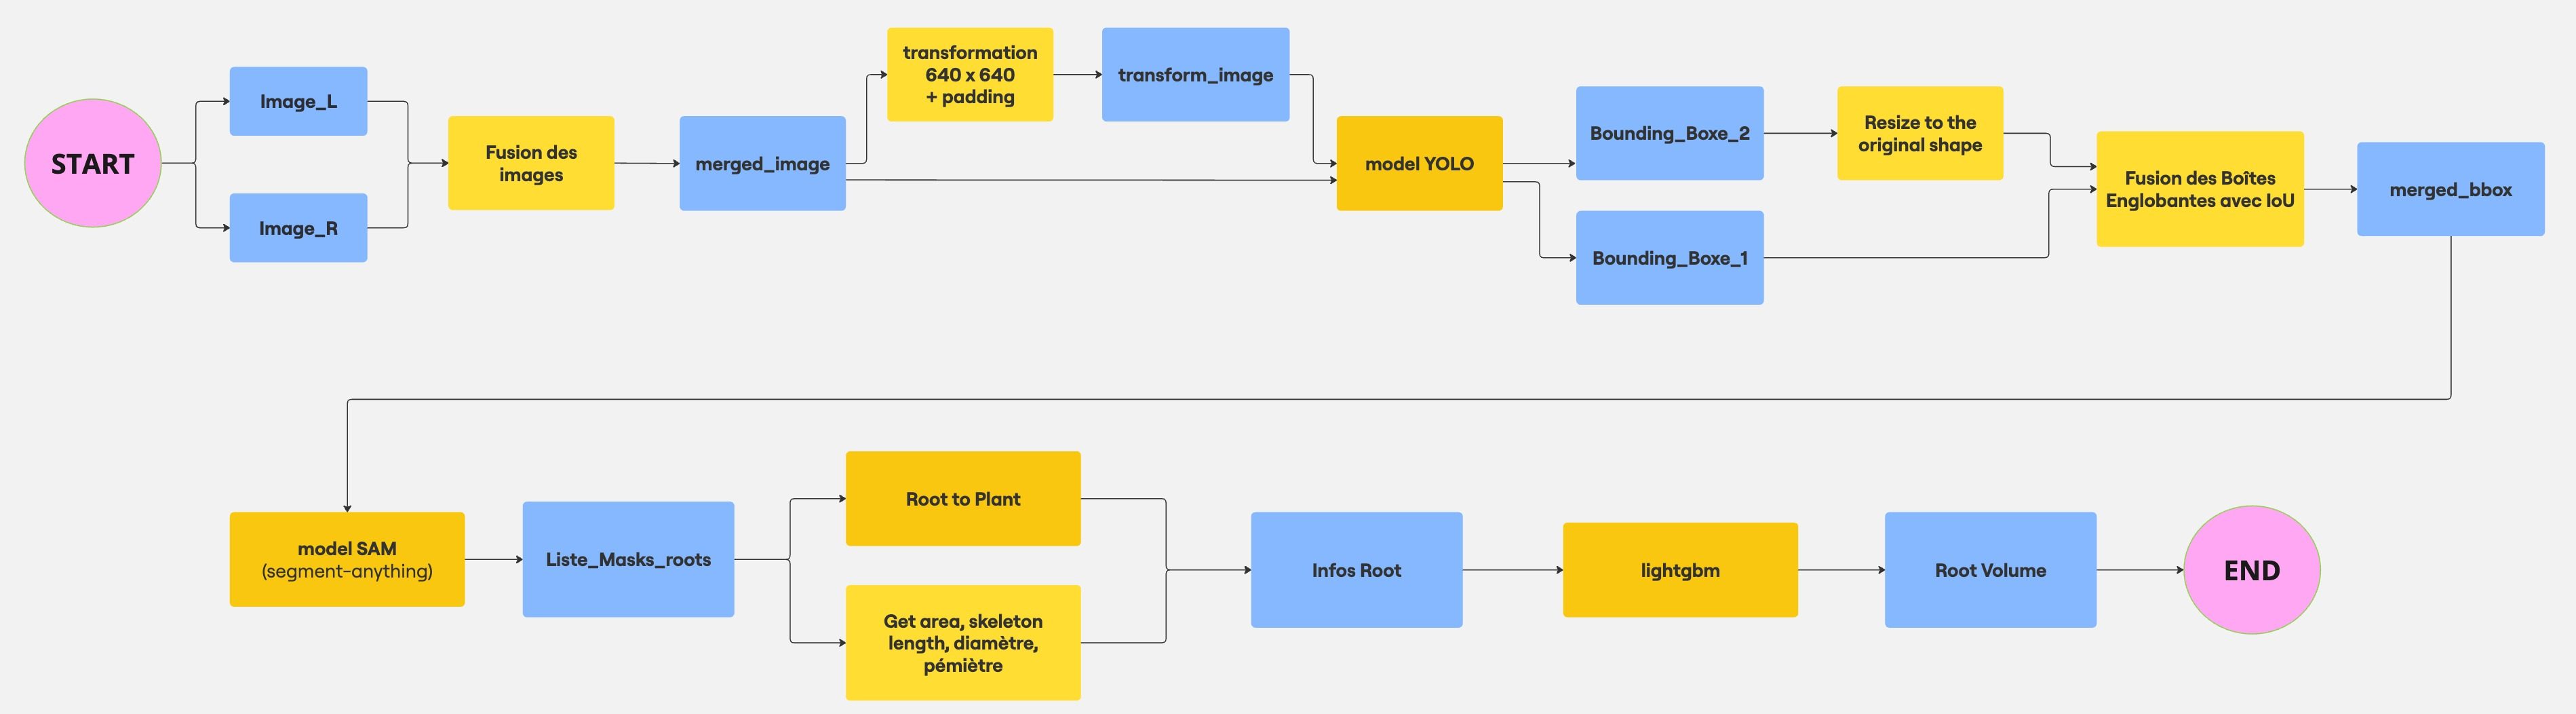


**Figure 5 : Pipeline du processing de la donnée à l'entrainement du model**


- **Bleu** : Variables
- **Jaune** : Fonctions simples
- **Orange** : Modèles utilisés


### 1. Explication du pipeline de traitement pour la segmentation des racines


1. **Détection initiale avec YOLO**  
   YOLO est efficace pour générer des bounding boxes, mais la segmentation obtenue à partir de ces dernières manque de précision.

2. **Affinement avec Segment Anything**  
   Les bounding boxes générées par YOLO sont utilisées pour guider le modèle _Segment Anything_ dans la détection des racines. Le masque produit offre une segmentation précise de chaque racine.

3. **Classification**  
   Une fois la segmentation réalisée, un modèle de classification associe chaque racine détectée à la plante correspondante.

Au final, on obtient des données tabulaires concernant chaque racine à la couche _i_, comprenant :

- **L'aire** (nombre de pixels)
- **Le squelette**
- **Le diamètre**
- **Le périmètre**
- **Plante**
- **Score de confiance**

### Approches d'entraînement

Plusieurs approches sont envisageables pour l'entraînement :

- **Approche actuelle** :  
  Se concentre sur la sélection de la meilleure couche, c'est-à-dire celle ayant le meilleur score de confiance issu de la fusion des bounding boxes. Donc de YOLO.

- **Approche en cours d'exploration** :  
  Consiste à calculer la somme des pixels pour chaque couche.

Les cellules de code qui suivent sont organisées étape par étape, conformément au pipeline. Avant de commencer, nous chargeons les dépendances, les modèles et les données d'entraînement.


### 2. Préparation de l'environnement et téléchargement des données


Ce script prépare l'environnement en effectuant les opérations suivantes de manière concise :

1. **Nettoyage initial**  
   Supprime le dossier `sample_data` s'il existe.

2. **Définition de la fonction `load_datas`**  
   Télécharge un fichier (ZIP par défaut) depuis une URL (notamment Google Drive) et l'extrait dans le dossier spécifié, en supprimant le fichier compressé après extraction.

3. **Génération de l'URL Google Drive**  
   Utilise une fonction lambda pour créer l'URL de téléchargement à partir d'un identifiant.

4. **Téléchargement des données**  
   Détermine le dossier d'extraction (`sam_yolo_approche`), génère l'URL du jeu de données et appelle `load_datas` pour récupérer et extraire les données.

5. **Installation des dépendances**  
   Exécute une commande pip pour installer OpenCV, Matplotlib, Ultralytics (pour YOLO) et le modèle Segment Anything depuis GitHub.


In [ ]:
import os
import sys
import json
import pickle
import shutil
import zipfile

import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches


DATA_DIR = "sample_data"
if os.path.exists(DATA_DIR):
    shutil.rmtree(DATA_DIR)
else:
    print("Le dossier n'existe pas.")


def load_datas(url, extract_dir, dow_name="TO_DELETE", file_type="zip"):
    """
    Télécharge et extrait un fichier de données depuis une URL.

    Args:
        url (str): L'URL du fichier à télécharger.
        extract_dir (str): Le dossier où extraire les données.
        dow_name (str, optional): Le nom de téléchargement du fichier. Defaults to "TO_DELETE".
        file_type (str, optional): Le type de fichier à télécharger. Defaults to "zip".
    """
    file_path = f"{dow_name}.{file_type}"

    os.makedirs(extract_dir, exist_ok=True)

    if file_type == "zip":
        gdown.download(url, file_path, quiet=False)

        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

        os.remove(file_path)
        print(f"Extraction terminée dans le dossier : {extract_dir}")
    else:
        gdown.download(url, os.path.join(extract_dir, file_path), quiet=False)

url_gg_drive = lambda file_id: f"https://drive.google.com/uc?id={file_id}"

extract_dir = "sam_yolo_approche"

# Chargement des models
url_train_test = url_gg_drive("1n3Ck9gfRFpHW7yeKnJlKcCpp-E9ZynoI")
load_datas(url_train_test, extract_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1n3Ck9gfRFpHW7yeKnJlKcCpp-E9ZynoI
From (redirected): https://drive.google.com/uc?id=1n3Ck9gfRFpHW7yeKnJlKcCpp-E9ZynoI&confirm=t&uuid=3c3e843e-77de-4dfd-bd90-d93858fb0778
To: /content/TO_DELETE.zip
100%|██████████| 2.88G/2.88G [00:55<00:00, 51.5MB/s]


Extraction terminée dans le dossier : sam_yolo_approche


### 3. Initialisation et configuration des modèles de vision par ordinateur


Ce **script** a pour objectif d'**initialiser** et de **configurer** plusieurs modèles pour la vision par ordinateur et la classification :

- **SAM** (Segment Anything Model) pour la segmentation d'images.
- **YOLO** pour la détection d'objets.
- Un **modèle de classification** (chargé via pickle) pour associer des **racines** à des **plantes**.

Les **chemins d'accès** aux poids et aux fichiers de configuration sont spécifiés, et l'**appareil de calcul** (`device`) est choisi en fonction de la disponibilité (MPS, CUDA ou CPU).


In [ ]:

SAM_CHECKPOINT_PATH = "./sam_yolo_approche/models/sam/sam_vit_h_4b8939.pth"
SAM_MODEL_TYPE = "vit_h"

# Chargement du modèle SAM depuis le registre et transfert sur l'appareil sélectionné
sam = sam_model_registry[SAM_MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device=device)

# Configuration du modèle YOLO
YOLO_WEIGHTS_PATH = "sam_yolo_approche/models/yolo/best_data_augm_transaltion.pt"
yolo = YOLO(YOLO_WEIGHTS_PATH)
yolo.to(device=device)

# Chargement du modèle de classification (Racines vers Plantes)
CLASSIFICATION_PICKLE_PATH = 'sam_yolo_approche/models/root2plant/classify_roots_for_plant_0_to_6.pkl'
with open(CLASSIFICATION_PICKLE_PATH, 'rb') as file:
    root2plant = pickle.load(file)
print("Modèles chargés")

Modèles chargés


1. **Affichage d'une image**  
   La fonction `display_image` utilise Matplotlib pour afficher une image. Elle convertit l'image (si nécessaire) et masque les axes.

2. **Chargement des images par couche**  
   La fonction `get_images_layer_by_layer` parcourt un dossier donné, assemble les images gauche (`_L_`) et droite (`_R_`) pour chaque couche, et stocke le tout dans un dictionnaire.

3. **Empilement vertical avec padding**  
   La fonction `vertical_stack_with_padding` empile verticalement deux images. Si leurs largeurs diffèrent, elle ajoute un padding sur l'axe des colonnes pour les aligner correctement.

4. **Création d'une image composite**  
   La fonction `get_image` prend une paire d'images d'une couche donnée, affiche l'image droite originale, la fait pivoter de 180° puis l'affiche, et enfin les empile verticalement pour créer une image composite.

5. **Exécution**  
   Le script définit un identifiant de dossier (`search_term`), charge les images depuis un chemin donné, affiche chaque couche, puis affiche une couche spécifiée (par exemple, la couche 20).


LAYER : 1


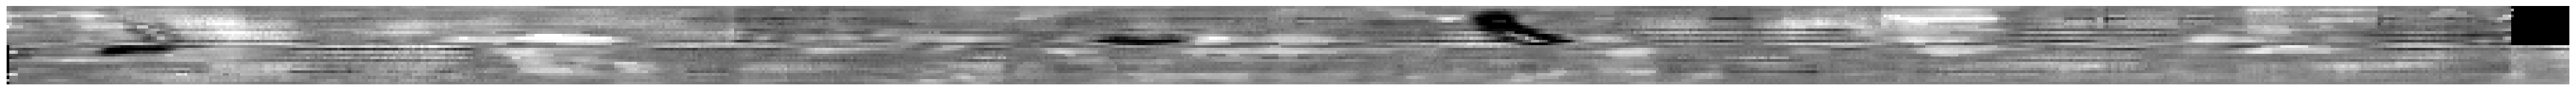

LAYER : 6


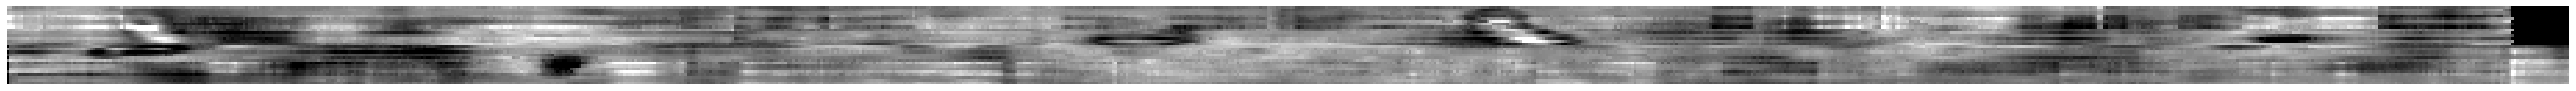

LAYER : 11


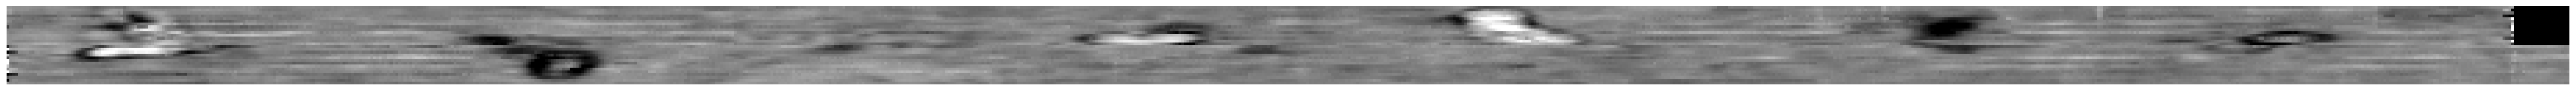

LAYER : 16


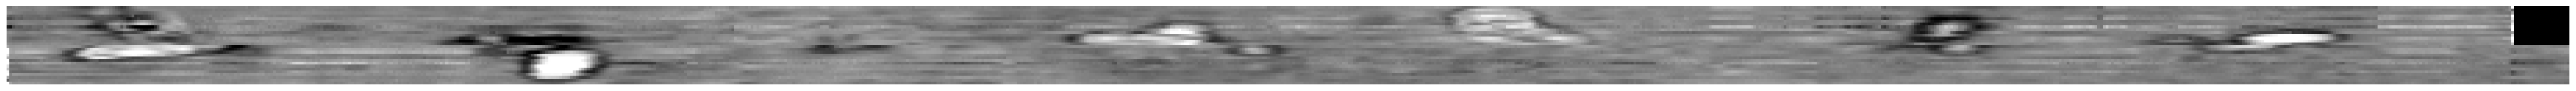

LAYER : 21


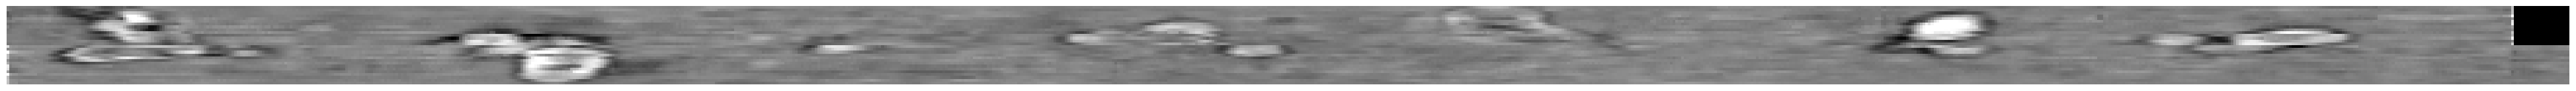

LAYER : 26


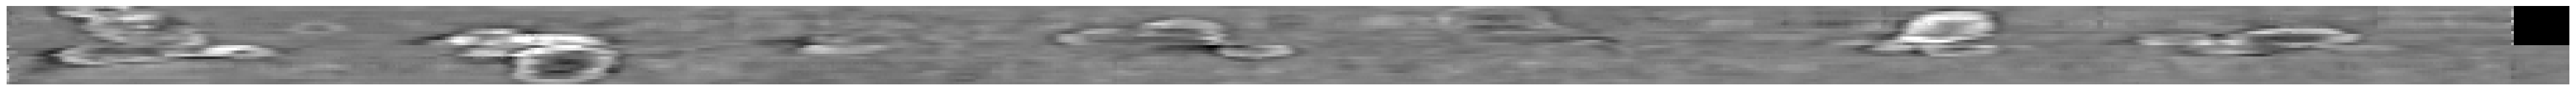

LAYER : 31


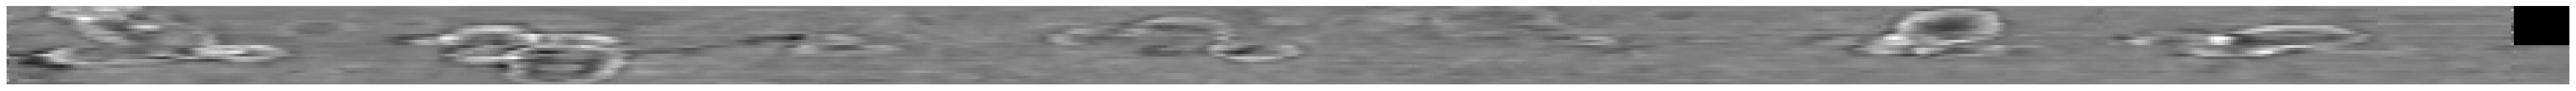

LAYER : 36


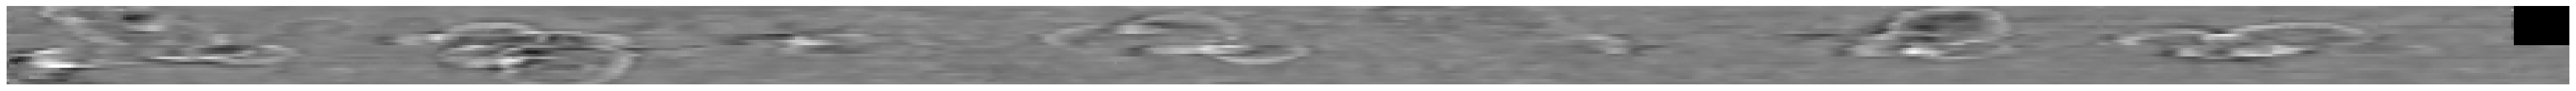

LAYER : 41


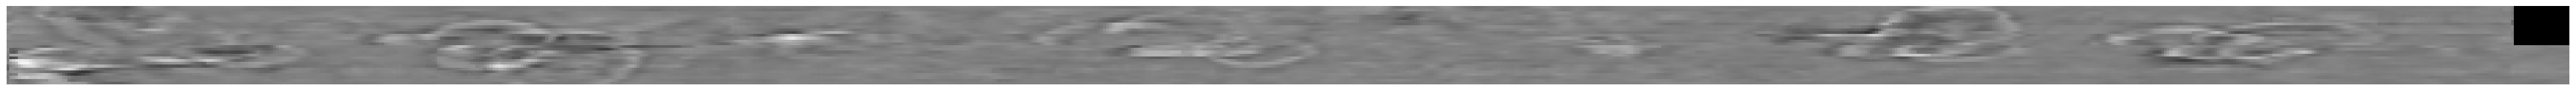

LAYER : 46


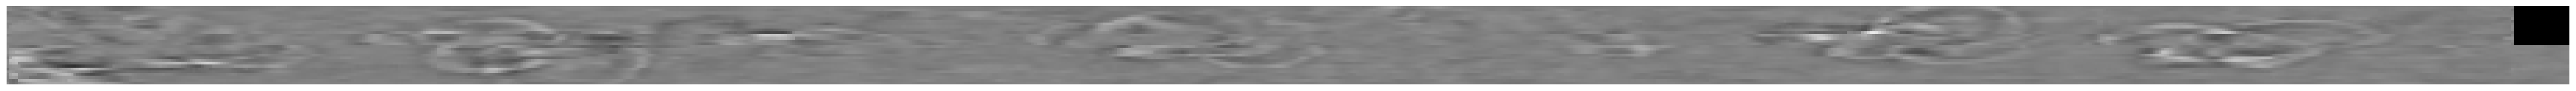

LAYER : 51


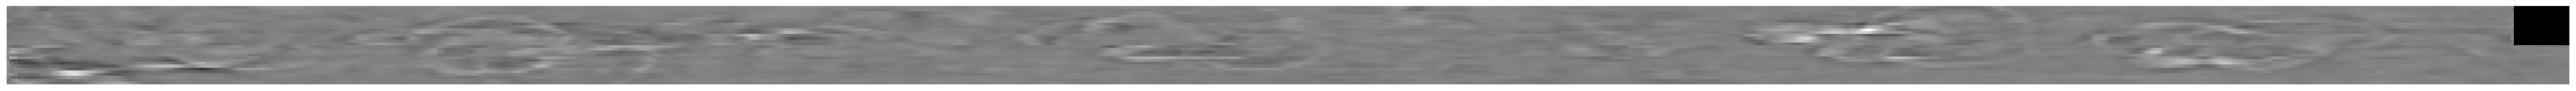

LAYER : 56


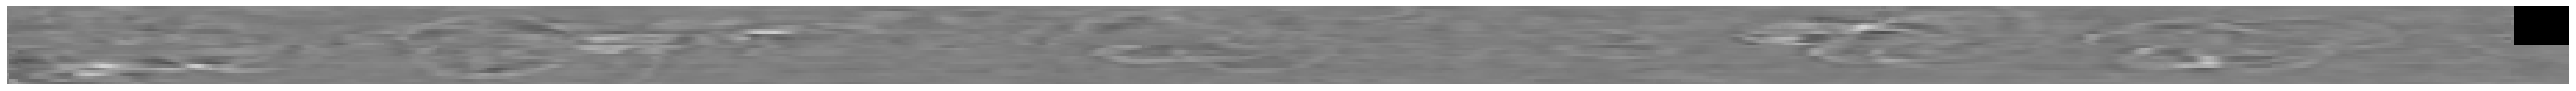

LAYER : 61


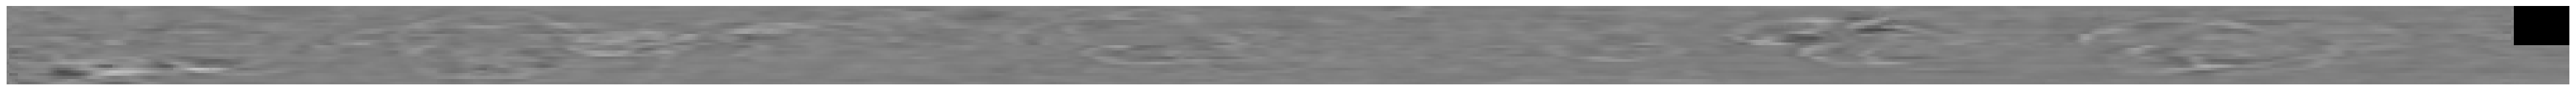

LAYER : 66


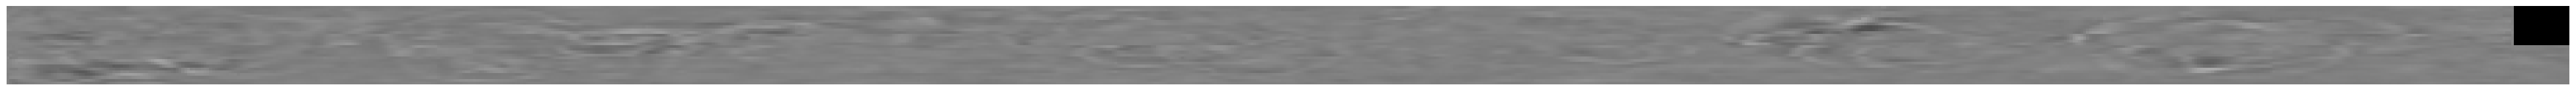

LAYER : 71


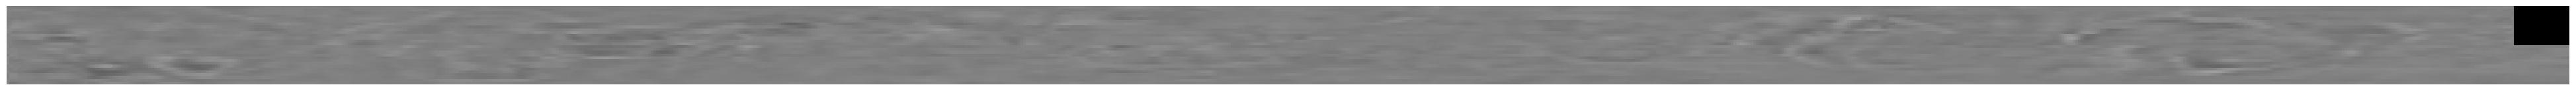

LAYER : 76


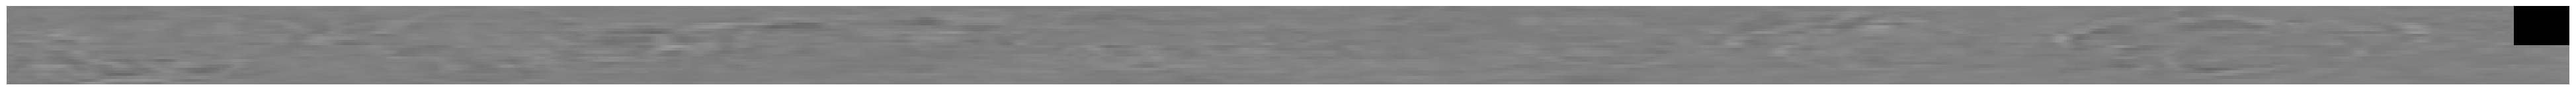

LAYER : 81


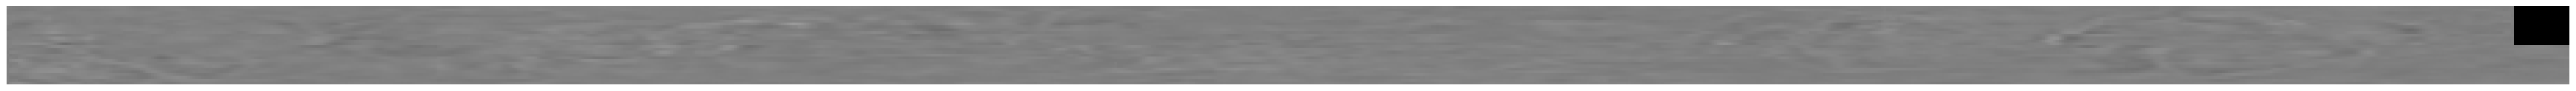

In [ ]:
def display_image(image):
    """
    Affiche l'image en utilisant Matplotlib.

    Args:
        image: Image à afficher.
    """
    plt.figure(figsize=(50, 50))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


def get_images_layer_by_layer(dir_name, path):
    path_final = os.path.join(path, dir_name)
    layers = dict()
    for layer in range(1, len(os.listdir(path_final))//2+1):
        layer_ = str(layer)
        if len(layer_) == 1:
            layer_ = '0'*2+layer_
        else:
            layer_ = '0'+layer_
        image_L = cv2.imread(os.path.join(
            path_final, dir_name+'_L_'+layer_+".png"))
        image_R = cv2.imread(os.path.join(
            path_final, dir_name+'_R_'+layer_+".png"))
        layers[layer] = [image_L, image_R]
    return layers


def vertical_stack_with_padding(arr1, arr2, pad_value=0):
    """
    Empile verticalement deux arrays (arr1 au-dessus de arr2) en ajoutant du padding
    sur l'axe des colonnes si leurs largeurs diffèrent.
    """
    h1, w1, c1 = arr1.shape
    h2, w2, c2 = arr2.shape

    if c1 != c2:
        raise ValueError(
            "Les tableaux doivent avoir le même nombre de canaux.")

    common_width = max(w1, w2)

    pad_w1 = common_width - w1
    pad_w2 = common_width - w2

    arr1_padded = np.pad(arr1, ((0, 0), (0, pad_w1), (0, 0)),
                         mode='constant', constant_values=pad_value)
    arr2_padded = np.pad(arr2, ((0, 0), (0, pad_w2), (0, 0)),
                         mode='constant', constant_values=pad_value)
    combined = np.concatenate((arr1_padded, arr2_padded), axis=0)
    return combined


def get_image(layers, index):
    image_L, image_R = layers[index]
    new_R = cv2.rotate(image_R, cv2.ROTATE_180)
    image = vertical_stack_with_padding(new_R, image_L)
    return image


search_term = 'Nto14cbfiw'
layer = 20
path = 'sam_yolo_approche/images/train'

layers = get_images_layer_by_layer(search_term, path)
for key in list(layers.keys())[0::5]:
    print(f'LAYER : {key}')

    image = get_image(layers, key)

    display_image(image)
image = get_image(layers, layer)

Ce premier code révèle bien une vue en plongée (top-down) qui montre que chaque couche correspond à une profondeur plus importante dans le sol. Voici les observations principales :

- **Couche 17** : Les 7 plantes sont clairement visibles.
- **À partir de la couche 56** : Il devient difficile de distinguer les racines à l'œil nu.

---


### 5. Redimensionnement de l'image, détection via YOLO et affichage


- **Redimensionnement avec padding**  
  La fonction `resize_image_with_padding` redimensionne l'image en conservant son ratio et ajoute un padding pour atteindre la taille cible (ici 640x640).

- **Prédiction YOLO**  
  Le modèle YOLO est appliqué sur l'image redimensionnée et sur l'image originale avec un seuil de confiance de 0.1.

- **Extraction des bounding boxes**  
  La fonction `extract_yolo_bounding_boxes` récupère les coordonnées des boîtes englobantes (format `[x_min, y_min, x_max, y_max, confidence]`).

- **Affichage des résultats**  
  La fonction `draw_bounding_boxes` dessine des rectangles rouges sur les images, qui sont ensuite affichées via `display_image`.



0: 640x640 14 racines, 5706.6ms
Speed: 30.4ms preprocess, 5706.6ms inference, 128.9ms postprocess per image at shape (1, 3, 640, 640)

0: 32x640 13 racines, 352.7ms
Speed: 0.7ms preprocess, 352.7ms inference, 3.4ms postprocess per image at shape (1, 3, 32, 640)


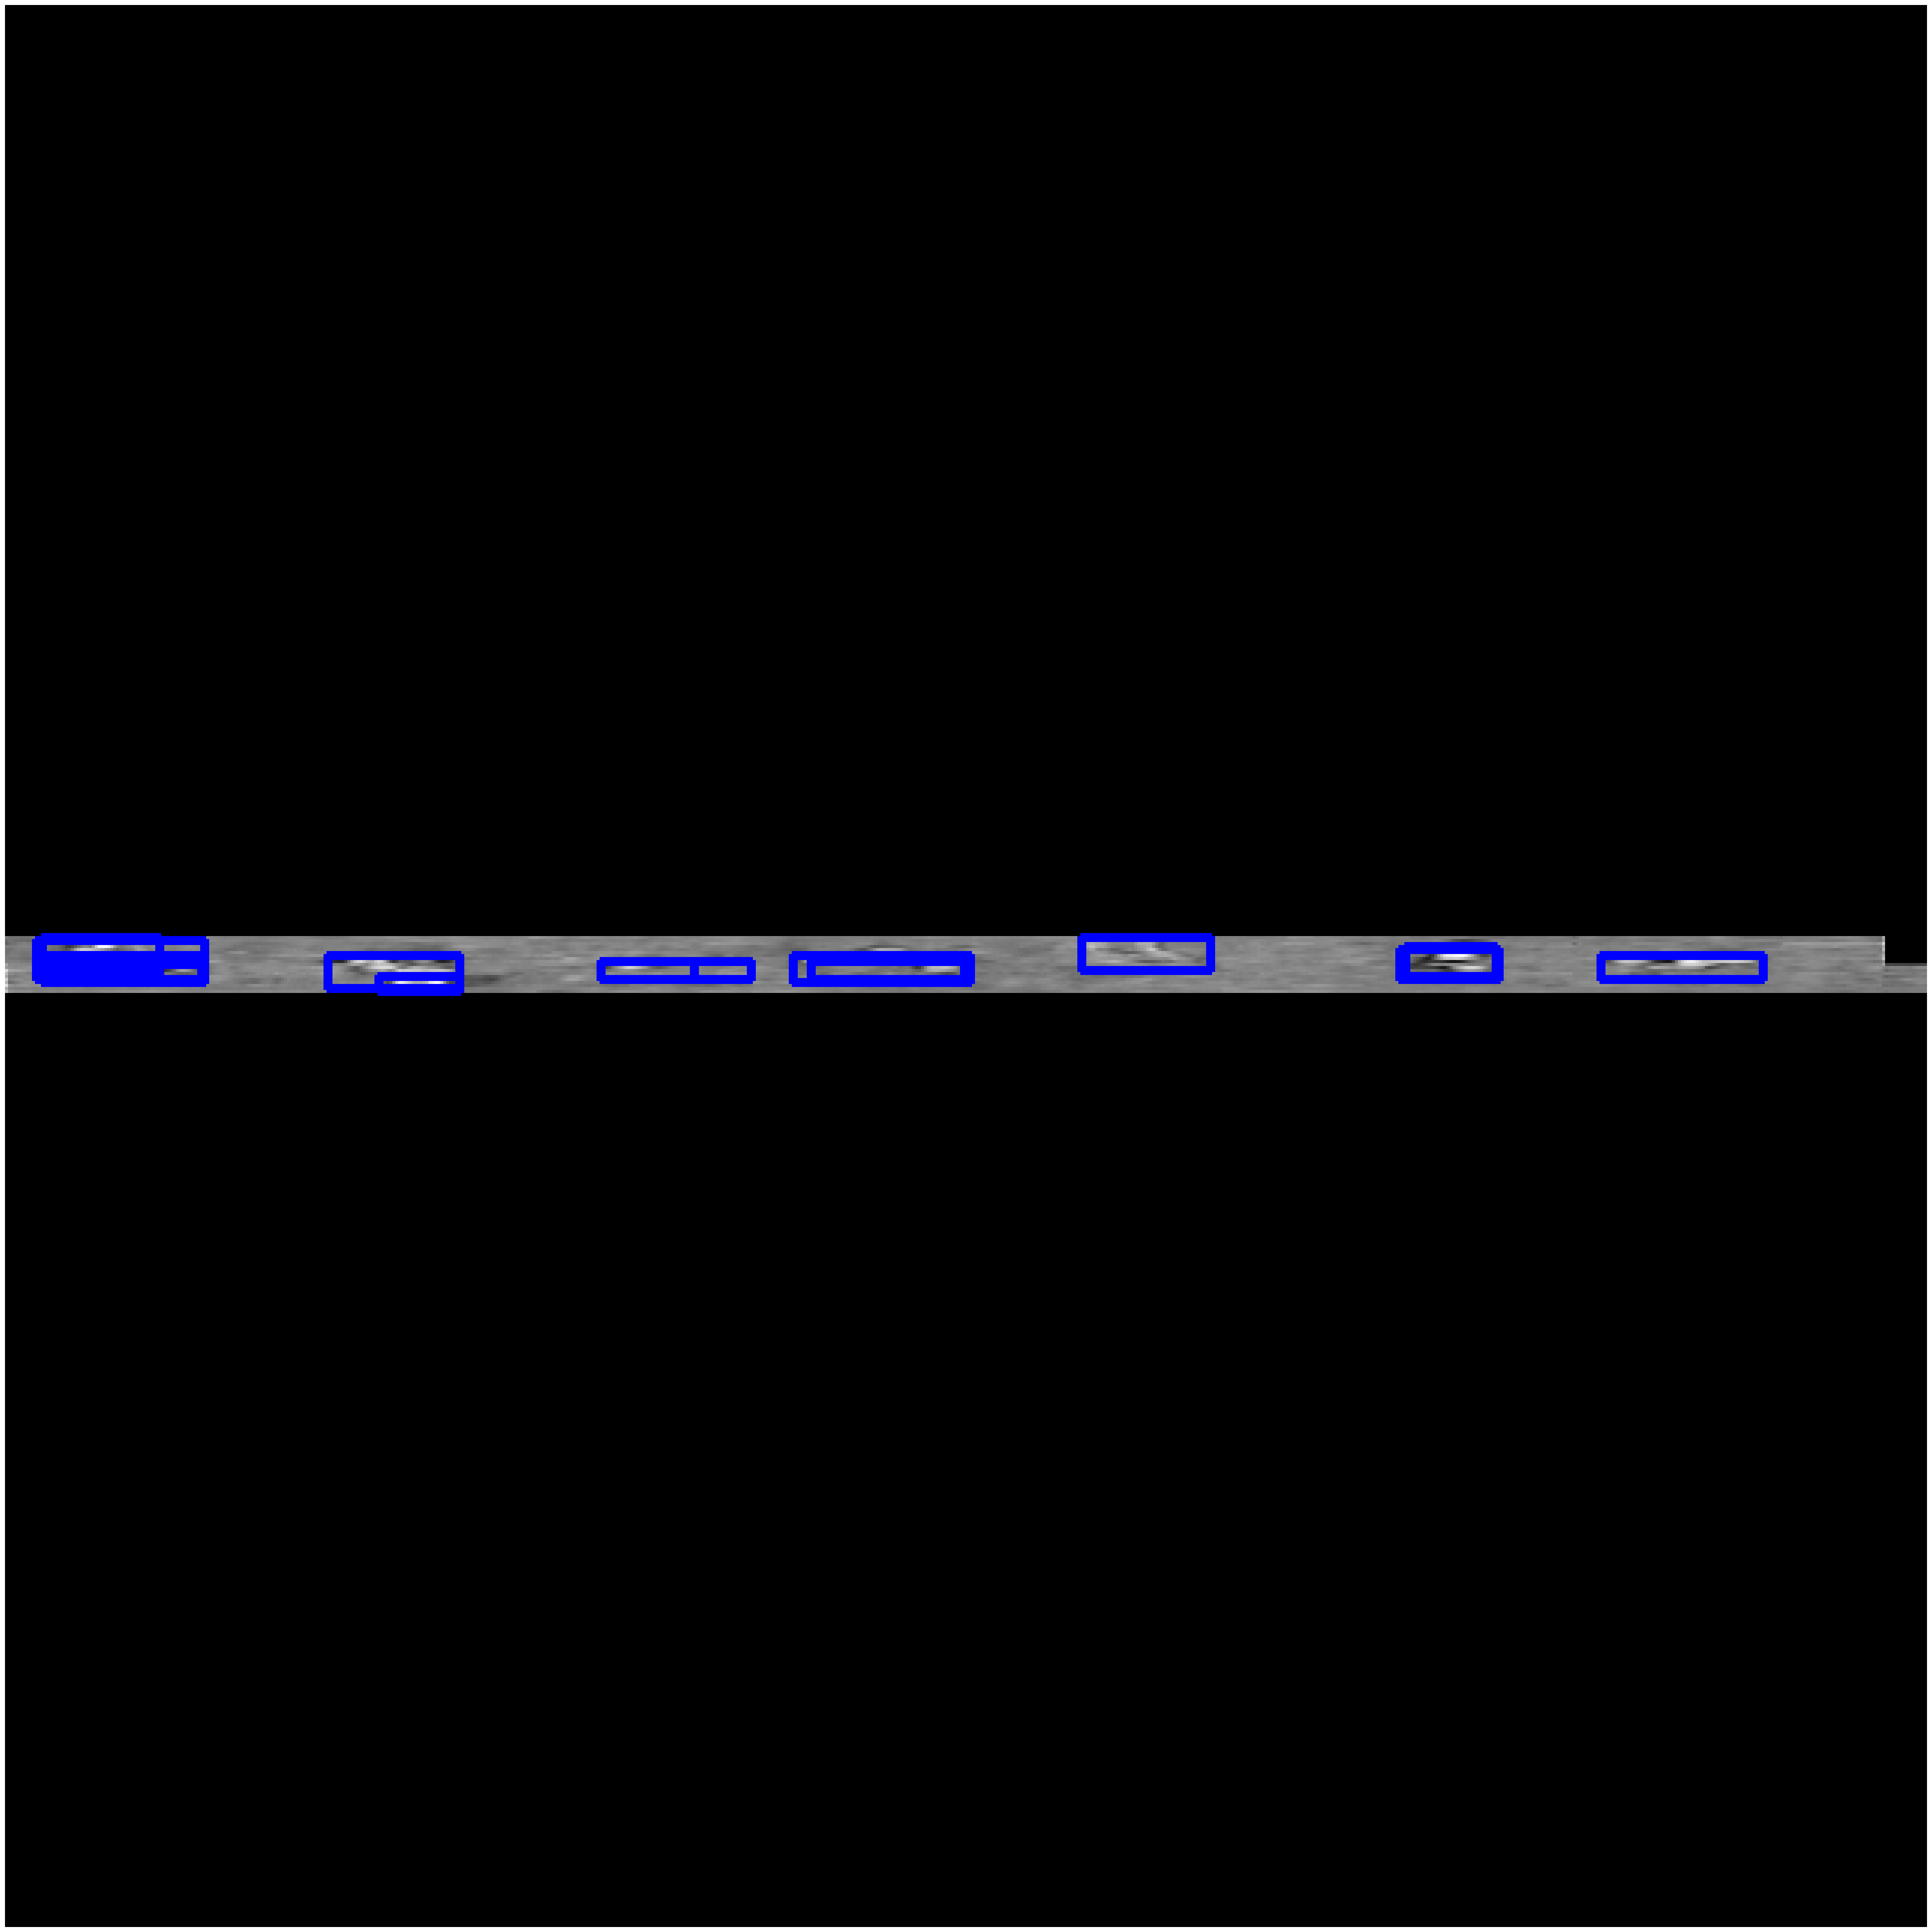

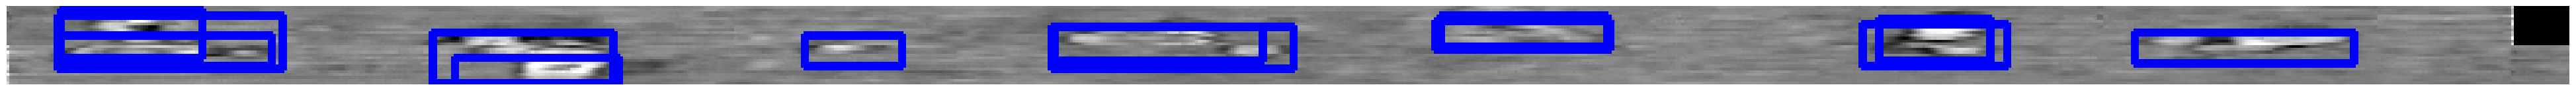

In [ ]:
def resize_image_with_padding(image, target_size):
    """
    Redimensionne une image tout en préservant son ratio et ajoute du padding pour atteindre la taille cible.

    Args:
        image (ndarray): Image d'entrée.
        target_size (tuple): Taille cible (largeur, hauteur).

    Returns:
        tuple: (canvas, scale_factor, pad_width, pad_height)
            - canvas (ndarray): Image redimensionnée avec padding.
            - scale_factor (float): Facteur de redimensionnement appliqué.
            - pad_width (int): Padding horizontal ajouté.
            - pad_height (int): Padding vertical ajouté.
    """
    original_height, original_width = image.shape[:2]
    target_width, target_height = target_size

    scale_factor = min(target_width / original_width,
                       target_height / original_height)
    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)

    resized_image = cv2.resize(image, (new_width, new_height))

    canvas = np.zeros((target_height, target_width, 3), dtype=image.dtype)

    pad_width = (target_width - new_width) // 2
    pad_height = (target_height - new_height) // 2

    canvas[pad_height:pad_height + new_height,
           pad_width:pad_width + new_width] = resized_image

    return canvas, scale_factor, pad_width, pad_height


# Application de la fonction sur une image avec une taille cible de 640x640
resized_image, scale, pad_width, pad_height = resize_image_with_padding(
    image, (640, 640))
confidence_threshold = 0.1

# Prédiction des bounding boxes avec YOLO sur l'image redimensionnée et l'image originale
predictions_resized = yolo(resized_image, conf=confidence_threshold)
predictions_original = yolo(image, conf=confidence_threshold)


def extract_yolo_bounding_boxes(prediction):
    """
    Extrait les coordonnées des bounding boxes depuis l'objet de prédiction YOLO.

    Args:
        prediction: Résultat du modèle YOLO (prédiction).

    Returns:
        ndarray: Tableau des bounding boxes au format [x_min, y_min, x_max, y_max, confidence].
    """
    bounding_boxes = []
    boxes = prediction[0]
    for box in boxes.boxes:
        bbox = box.xyxy[0].tolist() + [box.conf.item()]
        bounding_boxes.append(bbox)
    return np.array(bounding_boxes)


# Extraction des bounding boxes pour chaque prédiction
boxes_resized = extract_yolo_bounding_boxes(predictions_resized)
boxes_original = extract_yolo_bounding_boxes(predictions_original)


def draw_bounding_boxes(image, boxes, use_xywh=False):
    """
    Dessine des bounding boxes sur une copie de l'image.

    Args:
        image (ndarray): Image sur laquelle dessiner les boîtes.
        boxes (list): Liste des bounding boxes.
        use_xywh (bool): Si True, le format des boxes est (x, y, w, h), sinon (x_min, y_min, x_max, y_max).

    Returns:
        ndarray: Image annotée avec les bounding boxes.
    """
    image_copy = image.copy()
    for box in boxes:
        if use_xywh:
            x_min, y_min, width, height = map(int, box)
            x_max = x_min + width
            y_max = y_min + height
        else:
            x_min, y_min, x_max, y_max = map(int, box)
        # Dessiner le rectangle en rouge
        cv2.rectangle(image_copy, (x_min, y_min),
                      (x_max, y_max), (0, 0, 255), 2)
    return image_copy


display_image(draw_bounding_boxes(resized_image, [
              list(box[:4]) for box in boxes_resized]))
display_image(draw_bounding_boxes(
    image, [list(box[:4]) for box in boxes_original]))

- **Modèle YOLO**  
  Le modèle utilisé est celui fourni par le concours _best_full_, nous l'avons à nouveau finetuné sur des images de 640x640 issues des annotations du dossier `sam_yolo_approche/annotations_racines`.

- **Augmentation des données**  
  Pour pallier le faible volume de données, une augmentation a été effectuée par translation aléatoire. L'image conserve sa taille puisque les pixels disparus d'un côté réapparaissent de l'autre (effet de **tessellation**).

- **Seuil de confiance et fusion des détections**  
  Le seuil de confiance a été réduit à 0.1 pour augmenter le nombre de détections. La combinaison des bounding boxes issues de prédictions sur l'image originale et sur l'image augmentée permet de maximiser la détection des racines.


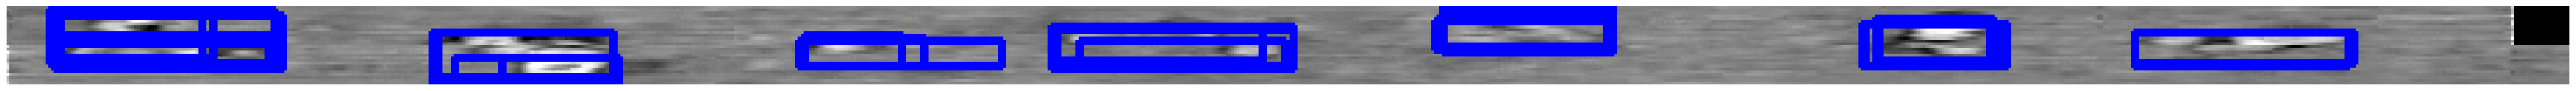

In [ ]:
def transform_to_original_coordinates(boxes, pad_width, pad_height, scale_factor):
    """
    Transforme les coordonnées des bounding boxes de l'image redimensionnée vers l'image originale.

    Args:
        boxes (array-like): Liste des bounding boxes.
        pad_width (int): Padding horizontal appliqué.
        pad_height (int): Padding vertical appliqué.
        scale_factor (float): Facteur de redimensionnement utilisé.

    Returns:
        list: Liste des bounding boxes transformées.
    """
    transformed_boxes = []
    for box in boxes:
        box_array = np.array(box)

        box_array[::2] = (box_array[::2] - pad_width) / scale_factor
        box_array[1::2] = (box_array[1::2] - pad_height) / scale_factor
        transformed_boxes.append(list(box_array))
    return transformed_boxes


boxes_resized_transformed = transform_to_original_coordinates(
    boxes_resized, pad_width, pad_height, scale)
boxes_original_transformed = transform_to_original_coordinates(
    boxes_original, 0, 0, 1)


combined_boxes = boxes_resized_transformed + boxes_original_transformed

display_image(draw_bounding_boxes(image, [box[:4] for box in combined_boxes]))

## 6. Fusion des boîtes englobantes

- **Calcul de l'IoU**  
  La fonction `compute_iou` calcule l'Intersection over Union entre deux boîtes ([x_min, y_min, x_max, y_max]) pour mesurer leur chevauchement.

- **Fusion de deux boîtes**  
  La fonction `merge_boxes` combine deux boîtes en prenant les coordonnées minimales et maximales et en concaténant leurs scores éventuels.

- **Fusion récursive des boîtes**  
  La fonction `merge_overlapping_boxes` parcourt les boîtes et fusionne celles dont l'IoU dépasse le seuil (ici 0.001) jusqu'à stabilisation du nombre de boîtes.

- **Affichage final**  
  Les coordonnées des boîtes fusionnées sont extraites pour être affichées sur l'image via `draw_bounding_boxes` et le nombre total de boîtes est affiché.


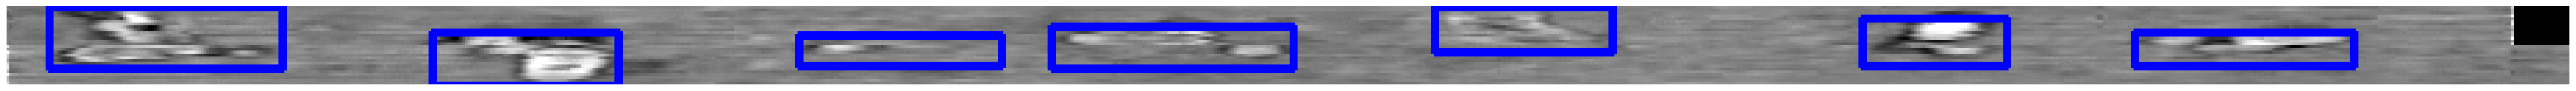

nombre de boxes : 7


In [ ]:
def compute_iou(box1, box2):
    """
    Calcule l'Intersection over Union (IoU) entre deux boîtes.

    Chaque boîte est définie par [x_min, y_min, x_max, y_max].

    Args:
        box1 (list): Coordonnées de la première boîte.
        box2 (list): Coordonnées de la deuxième boîte.

    Returns:
        float: Valeur de l'IoU.
    """

    x_min_inter = max(box1[0], box2[0])
    y_min_inter = max(box1[1], box2[1])
    x_max_inter = min(box1[2], box2[2])
    y_max_inter = min(box1[3], box2[3])

    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = area_box1 + area_box2 - inter_area

    return inter_area / union_area if union_area != 0 else 0


def merge_boxes(box1, box2):
    """
    Fusionne deux boîtes en combinant leurs coordonnées et scores.

    Args:
        box1 (list): Première boîte sous la forme [x_min, y_min, x_max, y_max, ...scores].
        box2 (list): Deuxième boîte sous la forme [x_min, y_min, x_max, y_max, ...scores].

    Returns:
        list: Boîte fusionnée avec les coordonnées min et max et la concaténation des scores.
    """
    x_min = min(box1[0], box2[0])
    y_min = min(box1[1], box2[1])
    x_max = max(box1[2], box2[2])
    y_max = max(box1[3], box2[3])

    scores_box1 = box1[4:]
    scores_box2 = box2[4:]
    return [x_min, y_min, x_max, y_max] + scores_box1 + scores_box2


def merge_overlapping_boxes(boxes, iou_thresh=0.5):
    """
    Fusionne les boîtes qui se chevauchent significativement.

    Pour chaque paire de boîtes, si leur IoU est supérieure ou égale au seuil,
    on fusionne les deux boîtes. Le processus se répète jusqu'à ce qu'aucune fusion
    supplémentaire ne soit possible.

    Args:
        boxes (list): Liste des boîtes à fusionner.
        iou_thresh (float, optional): Seuil d'IoU pour la fusion. Défaut à 0.5.

    Returns:
        list: Liste des boîtes fusionnées.
    """
    fusion_effectuee = True

    while fusion_effectuee:
        fusion_effectuee = False
        nouvelles_boites = []
        indices_a_sauter = set()
        nb_boites = len(boxes)

        for i in range(nb_boites):
            if i in indices_a_sauter:
                continue
            boite_courante = boxes[i]
            boite_fusion = boite_courante

            for j in range(i + 1, nb_boites):
                if j in indices_a_sauter:
                    continue
                boite_test = boxes[j]

                if compute_iou(boite_fusion, boite_test) >= iou_thresh:
                    boite_fusion = merge_boxes(boite_fusion, boite_test)
                    indices_a_sauter.add(j)
                    fusion_effectuee = True

            nouvelles_boites.append(boite_fusion)
        boxes = nouvelles_boites
    return boxes


merged_boxes = merge_overlapping_boxes(combined_boxes, iou_thresh=0.001)

scores = [box[4:] for box in merged_boxes]
merged_boxes_coords = [box[:4] for box in merged_boxes]

display_image(draw_bounding_boxes(image, merged_boxes_coords))
print(f'nombre de boxes : {len(merged_boxes_coords)}')

Dans cette image, **7 racines** ont été détectées.

- **Hypothèse** : Chaque racine détectée correspond à une plante.
- **Fusion des boîtes** : L'objectif est de fusionner toutes les boîtes englobantes qui se superposent.
- **Seuil IoU** : Pour ce faire, un seuil d'intersection (IoU) très faible, `iou_thresh=0.001`, est utilisé.

---


## 7. Segmentation plus fine avec SAM

En utilisant les boîtes englobantes issues de YOLO, nous améliorons la précision de la segmentation grâce à SAM.


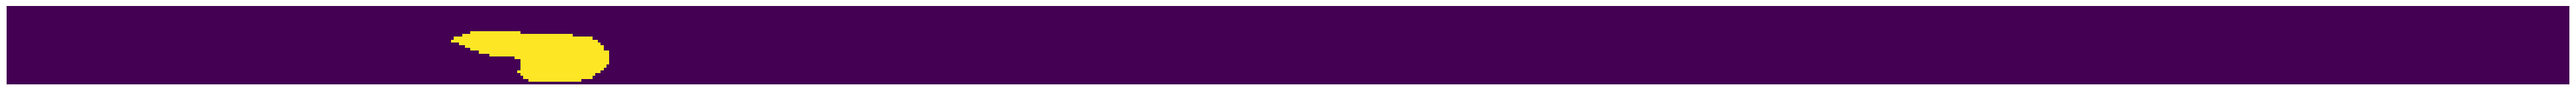

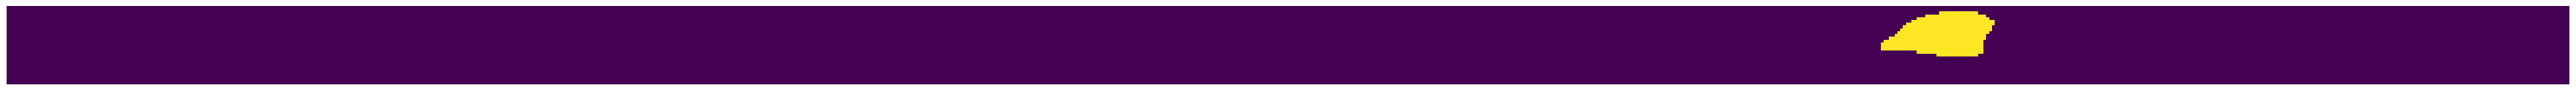

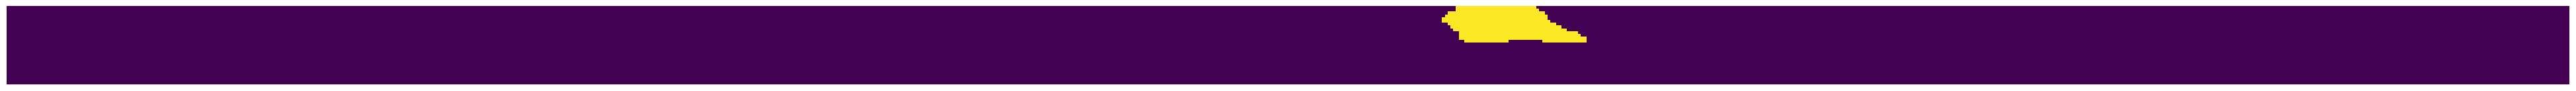

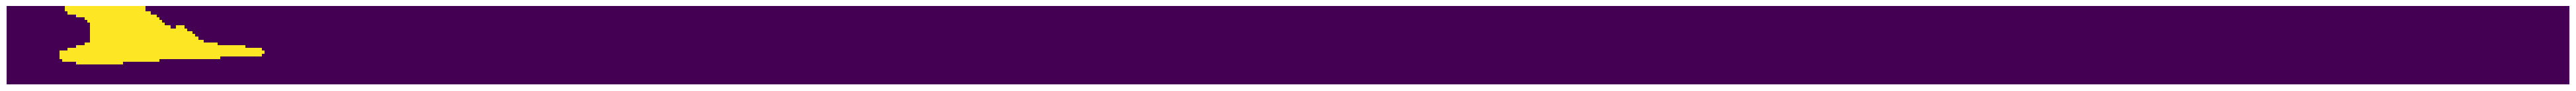

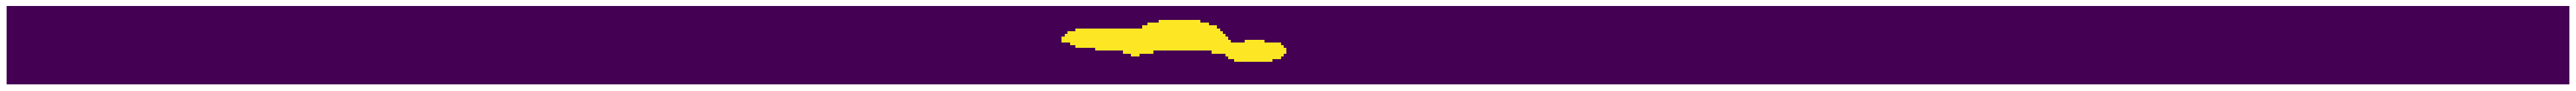

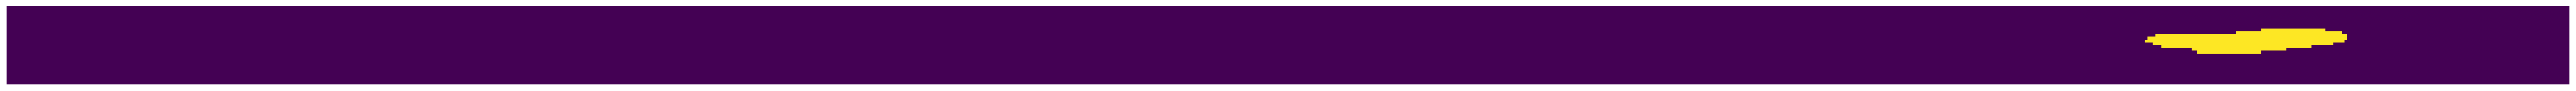

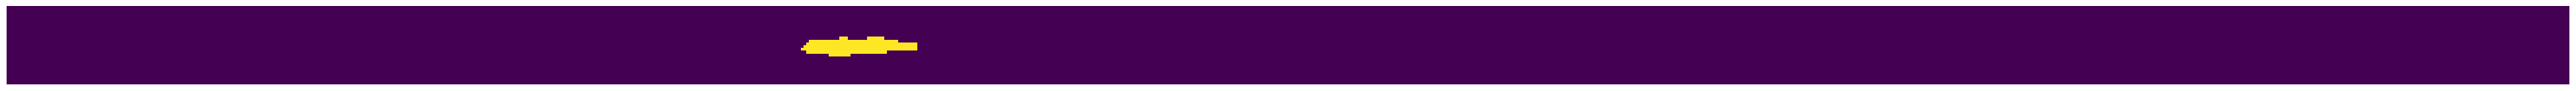

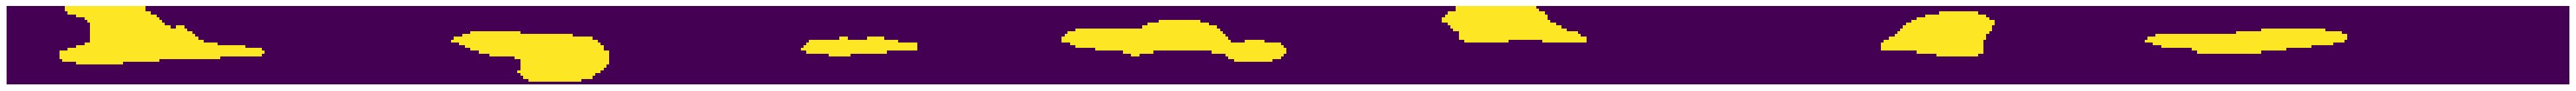

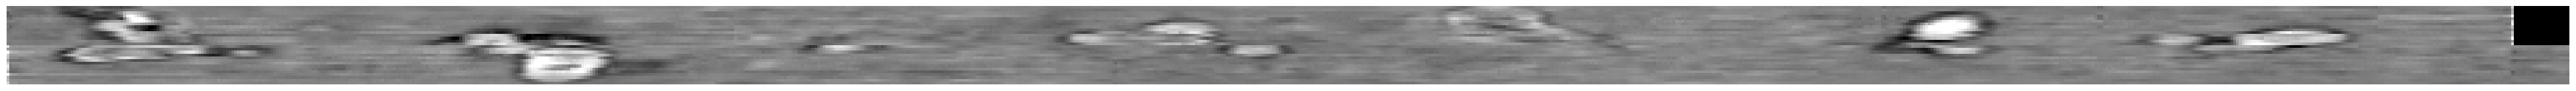

In [ ]:
predictor = SamPredictor(sam)
predictor.set_image(image)
masks = []

for boxe in merged_boxes_coords:
    mask, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=np.array([boxe]),
        multimask_output=False,
    )
    display_image(mask.squeeze(0))
    masks.append(mask)
masks = np.array(masks)
display_image(masks.max(axis=0).squeeze(0))
display_image(image)

- **Masques**  
  Les masques constituent un tableau booléen de dimensions `NxHxW`, où :

  - `HxW` représente la taille de l'image
  - `N` correspond au nombre de racines détectées

- **Segmentation précise**  
  Grâce au modèle SAM, chaque racine est segmentée avec précision.

- **Paramètres calculables**  
  Cette segmentation permet de mesurer divers paramètres, tels que :
  - La surface (en pixels)
  - Le squelette de la racine
  - Le diamètre
  - De nombreux autres paramètres liés au volume de la plante

---


## 8. Attribution des racines aux plantes

Chaque racine de l'image est précisément segmentée via le modèle SAM.

- **Annotation manuelle**  
  Un ensemble d'images sélectionnées manuellement a été annoté.  
  Chaque image contient 7 racines distinctes, en partant de l'hypothèse que chacune représente une plante, soit 7 plantes par image.

- **Modèle de classification**  
  Un modèle de classification, nommé **root2plant**, est entraîné sur ces données.  
  L'entraînement inclut une phase d'**auto-apprentissage** (self-training), dans laquelle le modèle s'auto-annote sur de nouvelles images jamais vues et ajuste ses poids en conséquence.

- **Visualisation**  
  Le code ci-dessous permet de visualiser les 7 zones correspondant aux 7 racines/plantes.


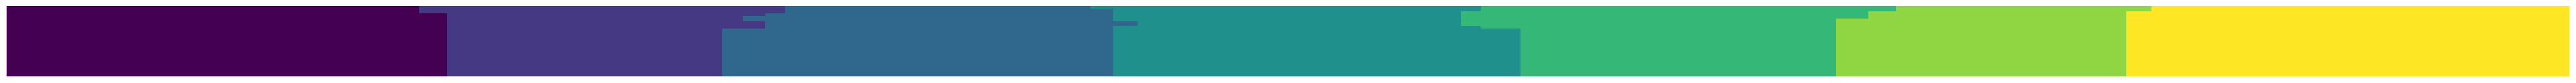

In [ ]:
height, width = image.shape[:2]
width = 1024
X = np.array([[y, x] for y in range(height) for x in range(width)])
pred_labels = root2plant.predict(X)

segmented_image = pred_labels.reshape((height, width))

display_image(segmented_image)

Limitations et perspectives du modèle

- **Adaptation de la taille d'image**  
  Le modèle a été entraîné sur une taille d'image spécifique, il est donc nécessaire de redimensionner les images pour qu'elles correspondent aux dimensions requises par l'entrée.

- **Délimitation des zones**  
  L'entraînement s'est effectué sur des images séparées (gauche et droite) avec une délimitation verticale. Pour des images fusionnées, les zones correspondant aux plantes seraient plus circulaires.

- **Amélioration de la classification**  
  L'application d'un clustering basé sur un modèle GMM constitue la prochaine étape pour optimiser la classification.

- **Ordre des labels**

  Les indices des labels varient de 0 à 6, de gauche à droite.
  Dans les images de gauche, les racines sont correctement orientées.
  Pour les images de droite, l'ordre des labels doit être inversé.

  (7 --> 1, 6 --> 2 , ... , 1 --> 7 )

---


- **Segmentation 2D**  
  La fonction `segmenter_tranche` extrait les pixels à 255 (ou 1), les regroupe avec DBSCAN et calcule le centroïde de chaque cluster.
  L'idée ici et de bien séparer les racines indivuellement.
  On aurait aussi pu appliquer une génération de bounding boxe.

- **Clustering 3D**  
  La fonction `clustering_3d` ajoute la coordonnée z aux clusters 2D, puis utilise DBSCAN en 3D pour fusionner les segments de la même racine.

- **Calcul des Caractéristiques**  
  La fonction `compute_root_features` mesure l’aire, le périmètre, la longueur du squelette et le diamètre moyen d'une racine.

- **Attribution et Association Finale**  
  Le code prétraite le volume en image binaire 3D, associe les clusters aux boîtes englobantes via l’IoU, prédit les labels et compile les résultats.


Nombre de clusters trouvés: 7


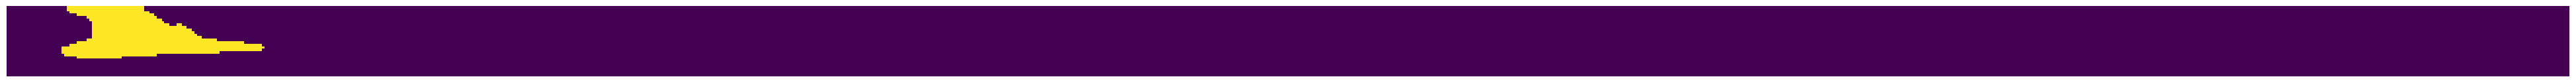

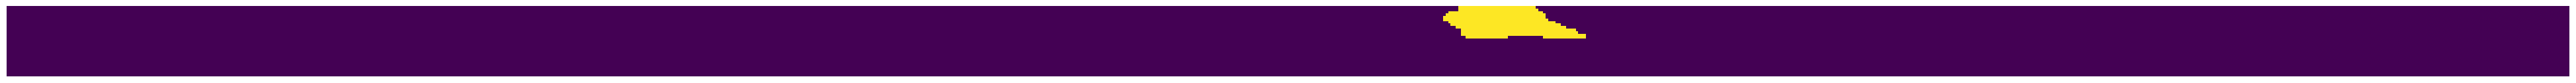

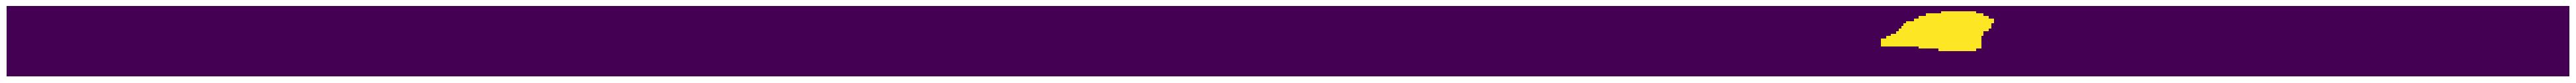

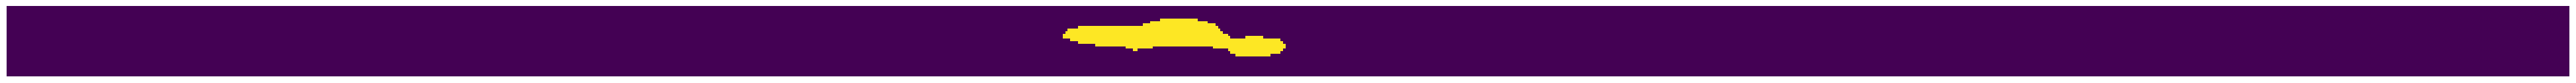

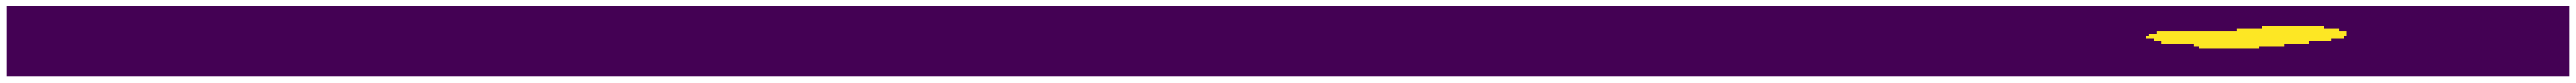

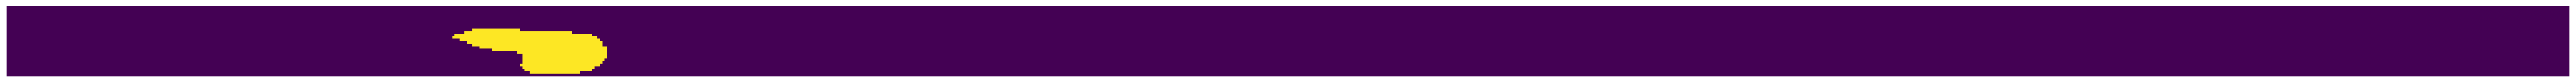

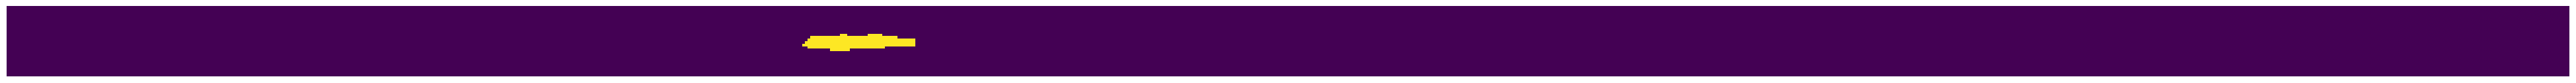

area   perimeter  skeleton_length  mean_diameter plantes        name  \
0   924  203.254833              122        7.57377     [0]  Nto14cbfiw   

   layer                                             scores  \
0     20  [0.8016349779441952, 0.7049468649085611, 0.700...   

                                              points  
0  [[0, 24], [0, 25], [0, 26], [0, 27], [0, 28], ...

In [ ]:
from sklearn.cluster import DBSCAN


def segmenter_tranche(slice_img, eps=5, min_samples=10):
    """
    Segmente une tranche (image 2D binaire) pour extraire les groupes de pixels à 255.

    Retourne une liste de dictionnaires contenant :
      - 'points'   : coordonnées des pixels du groupe
      - 'centroid' : centroïde du groupe (en 2D)

    Paramètres :
      - slice_img     : image 2D binaire
      - eps           : rayon maximum pour DBSCAN
      - min_samples   : nombre minimum de pixels pour former un cluster
    """
    # Extraire les coordonnées des pixels ayant la valeur 255
    coords_pixels = np.column_stack(np.where(slice_img == 255))
    if coords_pixels.shape[0] == 0:
        return []

    # Appliquer DBSCAN pour regrouper les pixels
    dbscan_2d = DBSCAN(eps=eps, min_samples=min_samples).fit(coords_pixels)
    labels = dbscan_2d.labels_

    clusters = []
    # Parcourir les clusters identifiés
    for label in np.unique(labels):
        if label == -1:  # Ignorer le bruit
            continue
        points_cluster = coords_pixels[labels == label]
        centroid_cluster = points_cluster.mean(axis=0)
        clusters.append({'points': points_cluster,
                        'centroid': centroid_cluster})

    return clusters


def clustering_3d(slices_volume, eps_slice=5, min_samples_slice=10, eps_3d=8):
    """
    Regroupe les segments extraits d'un volume 3D (séquence de tranches) pour rassembler
    les racines de la même plante.

    Paramètres :
      - slices_volume      : tableau 3D de dimensions (N, hauteur, largeur) représentant les tranches binaires
      - eps_slice          : paramètre eps pour DBSCAN en 2D
      - min_samples_slice  : paramètre min_samples pour DBSCAN en 2D
      - eps_3d             : seuil pour regrouper les centroïdes en 3D

    Retourne un dictionnaire où chaque clé correspond à un cluster 3D et la valeur est un
    tableau des coordonnées (x, y, z) de tous les pixels regroupés.
    """
    clusters_3d = []

    # Traitement tranche par tranche
    for z_index, slice_img in enumerate(slices_volume):
        clusters_2d = segmenter_tranche(
            slice_img, eps=eps_slice, min_samples=min_samples_slice)
        for cluster in clusters_2d:
            # Ajouter la coordonnée z aux centroïdes et aux points
            centroid_3d = np.append(cluster['centroid'], z_index)
            points_3d = np.column_stack(
                (cluster['points'], np.full(cluster['points'].shape[0], z_index)))
            clusters_3d.append(
                {'centroid_3d': centroid_3d, 'points_3d': points_3d})

    if len(clusters_3d) == 0:
        return {}

    # Récupérer les centroïdes 3D de chaque cluster extrait des tranches
    centroids_3d = np.array([cluster['centroid_3d']
                            for cluster in clusters_3d])

    # Appliquer DBSCAN en 3D pour regrouper les clusters voisins
    dbscan_3d = DBSCAN(eps=eps_3d, min_samples=1).fit(centroids_3d)
    labels_3d = dbscan_3d.labels_

    final_clusters = {}
    # Regroupement des points par cluster 3D
    for idx, label in enumerate(labels_3d):
        if label not in final_clusters:
            final_clusters[label] = []
        final_clusters[label].append(clusters_3d[idx]['points_3d'])

    # Fusionner les points de chaque cluster 3D en un seul tableau
    for label in final_clusters:
        final_clusters[label] = np.vstack(final_clusters[label])

    return final_clusters


def compute_root_features(binary_image):
    """
    Calcule plusieurs caractéristiques d'une zone binaire représentant une racine.

    Retourne un dictionnaire de caractéristiques contenant :
      - "area"           : aire (nombre de pixels non nuls)
      - "perimeter"      : périmètre (somme des longueurs des contours)
      - "skeleton_length": longueur du squelette (après amincissement)
      - "mean_diameter"  : diamètre moyen (rapport area / skeleton_length)

    Paramètres :
      - binary_image : image binaire représentant la racine
    """
    # Conversion de l'image au format uint8
    binary_image = binary_image.astype(np.uint8)
    area = np.count_nonzero(binary_image)

    # Extraction des contours
    contours, _ = cv2.findContours(
        binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    perimeter = sum(cv2.arcLength(contour, True) for contour in contours)

    try:
        skeleton = cv2.ximgproc.thinning(binary_image)
        skeleton_length = np.count_nonzero(skeleton == 255)
    except Exception as error:
        print("Erreur thinning:", error)
        skeleton_length = 0

    mean_diameter = area / skeleton_length if skeleton_length > 0 else 0

    features = {
        "area": area,
        "perimeter": perimeter,
        "skeleton_length": skeleton_length,
        "mean_diameter": mean_diameter
    }

    return features


volume_binary = masks.max(axis=0).astype(float).squeeze(0)
volume_binary[volume_binary == 1.] = 255.
volume_binary = cv2.resize(volume_binary, (1024, volume_binary.shape[0]))
volume_binary = volume_binary[None, :]

clusters_final = clustering_3d(
    volume_binary, eps_slice=5, min_samples_slice=5, eps_3d=8)

print("Nombre de clusters trouvés:", len(clusters_final))

results_data = []
for _, points_3d in clusters_final.items():
    predicted_labels = root2plant.predict(points_3d[:, :2])
    label_distribution = np.array(
        [(predicted_labels == class_idx).mean() for class_idx in range(7)])
    non_zero_indices = np.nonzero(label_distribution)[0]
    sorted_indices = non_zero_indices[np.argsort(
        label_distribution[non_zero_indices])[::-1]]

    img_cluster = np.zeros(volume_binary.shape[1:], dtype=np.uint8)
    img_cluster[points_3d[:, 0], points_3d[:, 1]] = 255
    display_image(img_cluster)  # Affichage de l'image

    root_features = compute_root_features(img_cluster)
    root_features['plantes'] = list(sorted_indices)

    iou_list = []
    for box in merged_boxes_coords:
        x_min, y_min, width, height = box
        x_max = x_min + width
        y_max = y_min + height

        y_pixels_max = points_3d[:, 0].max()
        y_pixels_min = points_3d[:, 0].min()
        x_pixels_max = points_3d[:, 1].max()
        x_pixels_min = points_3d[:, 1].min()
        iou_list.append(
            compute_iou([x_min, y_min, x_max, y_max],
                        [x_pixels_min, y_pixels_min, x_pixels_max, y_pixels_max])
        )

    best_box_index = np.argmax(iou_list)
    root_features['name'] = search_term
    root_features['layer'] = layer
    root_features['scores'] = scores[best_box_index]
    root_features['points'] = [list(point) for point in points_3d[:, :2]]

    results_data.append(root_features)
results_data = pd.DataFrame(results_data)
results_data.head(1)

- **Clustering des racines**  
  Le clustering segmente efficacement les racines.

- **Association aux plantes**  
  Les racines sont ensuite associées à leur plante via `root2plant`.

- **Calcul des caractéristiques**  
  Pour chaque racine, ses caractéristiques sont calculées.

- **Ré-association avec les scores YOLO**  
  Étant donné que l'indexation des boîtes englobantes a été abandonnée, les racines sont ré-associées à leurs scores YOLO via le calcul de l'IoU.

Le dataset final contient une ligne pour chaque racine détéctés

---


## 10. Code global de traitement des images


Ce code a pour **objectif** de traiter un ensemble d’images afin d'extraire des informations sur les racines de manioc. Il utilise notamment :

- `tqdm` pour le suivi de progression,
- `YOLO` pour la détection d’objets (`detection en couleur`),
- Un module de segmentation **SAM** pour générer des masques,
- Et un algorithme de clustering pour regrouper les racines par plantes : **root2plant**.


In [ ]:
#### CODE DÉJÀ EXÉCUTÉ POUR LA GÉNÉRATION
#### L'exécution de ce code est longue. Si vous souhaitez l'éviter, utilisez la cellule ci-dessous pour charger le dataset généré.

# from tqdm import tqdm


# def get_datas_from_images(path, confidence, output_csv_path, df):
#     """
#     Extrait des données à partir d'images situées dans un répertoire donné.

#     **Étapes clés :**
#     - Chargement et redimensionnement des images avec padding (`redimensionnement en couleur`)
#     - Détection d'objets via YOLO
#     - Transformation et fusion des boîtes englobantes
#     - Préparation et segmentation avec SAM
#     - Clustering 3D pour regrouper les racines et calcul de métriques associées
#     """
#     data_list = []

#     # Parcours unique des noms d'images basés sur le préfixe avant le premier '_'
#     base_names = os.listdir(path)
#     for search_term in tqdm(base_names):
#         try:
#             # Récupération des noms d'images associés à base_name
#             layers = get_images_layer_by_layer(search_term, path)

#             start = df[df['FolderName'] == search_term]['Start'].min()
#             end = df[df['FolderName'] == search_term]['End'].max()
#             for layer in tqdm(list(layers.keys())[start:end+1]):
#                 try:
#                     image = get_image(layers, layer)
#                     resized_image, scale, pad_width, pad_height = resize_image_with_padding(
#                         image, (640, 640))

#                     predictions_resized = yolo(resized_image, conf=confidence)
#                     predictions_original = yolo(image, conf=confidence)

#                     boxes_resized = extract_yolo_bounding_boxes(
#                         predictions_resized)
#                     boxes_original = extract_yolo_bounding_boxes(
#                         predictions_original)

#                     boxes_resized_transformed = transform_to_original_coordinates(
#                         boxes_resized, pad_width, pad_height, scale)
#                     boxes_original_transformed = transform_to_original_coordinates(
#                         boxes_original, 0, 0, 1)
#                     combined_boxes = boxes_resized_transformed + boxes_original_transformed

#                     merged_boxes = merge_overlapping_boxes(
#                         combined_boxes, iou_thresh=0.001)
#                     scores = [box[4:] for box in merged_boxes]
#                     merged_boxes_coords = [box[:4] for box in merged_boxes]

#                     predictor.set_image(image)
#                     masks = []
#                     for boxe in merged_boxes_coords:
#                         mask, _, _ = predictor.predict(
#                             point_coords=None,
#                             point_labels=None,
#                             box=np.array([boxe]),
#                             multimask_output=False,
#                         )
#                         masks.append(mask)
#                     masks = np.array(masks)

#                     volume_binary = masks.max(axis=0).astype(float).squeeze(0)
#                     volume_binary[volume_binary == 1.] = 255.
#                     volume_binary = cv2.resize(
#                         volume_binary, (1024, volume_binary.shape[0]))
#                     volume_binary = volume_binary[None, :]

#                     clusters_final = clustering_3d(
#                         volume_binary, eps_slice=5, min_samples_slice=5, eps_3d=8)

#                     for _, points_3d in clusters_final.items():
#                         # Prédiction des labels pour les points
#                         predicted_labels = root2plant.predict(points_3d[:, :2])
#                         # Calcul des fréquences d'apparition des labels (sur 7 classes)
#                         label_distribution = np.array(
#                             [(predicted_labels == class_idx).mean() for class_idx in range(7)])
#                         non_zero_indices = np.nonzero(label_distribution)[0]
#                         sorted_indices = non_zero_indices[np.argsort(
#                             label_distribution[non_zero_indices])[::-1]]

#                         # Création d'une image de test pour visualiser le cluster
#                         img_cluster = np.zeros(
#                             volume_binary.shape[1:], dtype=np.uint8)
#                         img_cluster[points_3d[:, 0], points_3d[:, 1]] = 255

#                         # Calcul des caractéristiques de la racine
#                         root_features = compute_root_features(img_cluster)
#                         root_features['plantes'] = list(sorted_indices)

#                         # Calcul des IoU pour associer le cluster à une boîte englobante
#                         iou_list = []
#                         for box in merged_boxes_coords:
#                             x_min, y_min, width, height = box
#                             x_max = x_min + width
#                             y_max = y_min + height

#                             y_pixels_max = points_3d[:, 0].max()
#                             y_pixels_min = points_3d[:, 0].min()
#                             x_pixels_max = points_3d[:, 1].max()
#                             x_pixels_min = points_3d[:, 1].min()
#                             iou_list.append(
#                                 compute_iou([x_min, y_min, x_max, y_max],
#                                             [x_pixels_min, y_pixels_min, x_pixels_max, y_pixels_max])
#                             )

#                         best_box_index = np.argmax(iou_list)
#                         root_features['name'] = search_term
#                         root_features['layer'] = layer
#                         root_features['scores'] = scores[best_box_index]
#                         root_features['points'] = [
#                             list(point) for point in points_3d[:, :2]]

#                         data_list.append(root_features)

#                 except Exception:
#                     continue
#         except Exception:
#             print('error')
#             print(search_term)
#             continue

#     results_df = pd.DataFrame(data_list)
#     results_df.to_csv(output_csv_path, sep=',', index=False)
#     return results_df


# output_csv_path = "sam_yolo_approche/datasets/TRAIN_DATA.csv"
# images_directory = "sam_yolo_approche/images/train"
# confidence = 0.1
# df_train = pd.read_csv("sam_yolo_approche/datasets/Train.csv", sep=',')


# get_datas_from_images(images_directory, confidence, output_csv_path, df_train)

# output_csv_path = "sam_yolo_approche/datasets/dataset_train.csv"
# images_directory = "sam_yolo_approche/images/test"
# confidence = 0.1
# df_test = pd.read_csv("./sam_yolo_approche/datasets/Test.csv", sep=',')


# get_datas_from_images(images_directory, confidence, output_csv_path, df_test)

- **Génération des datasets**  
  Ici, on génère les datasets de train et de test qui serviront de base pour nos prédictions.

- **Code non exécutable**  
  Le code est assez long et n'est pas destiné à être exécuté directement, car la cellule suivante charge déjà les datasets générés au préalable.


In [ ]:
extract_dir = "sam_yolo_approche/datasets"

url_test = url_gg_drive("1-GfzwaofJ37ZyTH4QufOKWefTEHEpRGS")
load_datas(url_test, extract_dir, dow_name="dataset_test", file_type='csv')

url_train = url_gg_drive("1-BkAoK2961trIWh7ktjza_t35dA-CN_K")
load_datas(url_train, extract_dir, dow_name="dataset_train", file_type='csv')

Downloading...
From: https://drive.google.com/uc?id=1-GfzwaofJ37ZyTH4QufOKWefTEHEpRGS
To: /content/sam_yolo_approche/datasets/dataset_test.csv
100%|██████████| 44.1M/44.1M [00:00<00:00, 52.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-BkAoK2961trIWh7ktjza_t35dA-CN_K
To: /content/sam_yolo_approche/datasets/dataset_train.csv
100%|██████████| 71.4M/71.4M [00:01<00:00, 61.0MB/s]


### 11. Entrainement et inférence du modèle de prédiction de la cible RootVolume


- **Chargement des datasets**  
  Ici, `dg` correspond au dataset issu de notre processing, et `df` est celui fourni par le concours.

- **Concaténation des datasets**  
  Les datasets `dg_test` et `dg_train` sont concaténés pour augmenter le nombre de racines disponibles.

- **Transformation de la colonne PlantNumber**  
  Pour les images du côté droit, une transformation est appliquée sur la colonne `PlantNumber` en raison de la rotation de 180° effectué lors de **l'étape 4**. Les racines, numérotées de 1 à 7 de gauche à droite, voient leur ordre inversé (par exemple, 7 devient 1), corrigé grâce à la formule `8 - num`.


In [ ]:
dg_test = pd.read_csv(f'./sam_yolo_approche/datasets/dataset_test.csv')
dg_train = pd.read_csv(f'./sam_yolo_approche/datasets/dataset_train.csv')
dg_train['train'] = 1
dg_test['train'] = 0
dg = pd.concat([dg_train, dg_test], axis=0).reset_index(drop=True)

df_train = pd.read_csv('./sam_yolo_approche/datasets/Train.csv')
df_test = pd.read_csv('./sam_yolo_approche/datasets/Test.csv')

df_test.loc[df_test['Side'] == 'R', 'PlantNumber'] = 8 - \
    df_test.loc[df_test['Side'] == 'R', 'PlantNumber']
df_train.loc[df_train['Side'] == 'R', 'PlantNumber'] = 8 - \
    df_train.loc[df_train['Side'] == 'R', 'PlantNumber']


display(df_train.head(1))
print('\n')
display(df_test.head(1))
print('\n')
display(dg.head(1))

ID  FolderName  PlantNumber Side  Start  End  RootVolume  \
0  ID_826322_Lbmaya  A6dzrkjqvl            3    L     33   42         0.9   

             Genotype  Stage  
0  IITA-TMS-IBA000070  Early

ID  FolderName  PlantNumber Side  Start  End  \
0  ID_208667_Hnkl8q  L5l1h3kekg            7    L     38   50   

             Genotype  Stage  
0  IITA-TMS-IBA000070  Early

area   perimeter  skeleton_length  mean_diameter    plantes        name  \
0  6122  655.036578              442      13.850679  [0, 1, 2]  Lwuwokuhrf   

   layer                 scores  \
0     16  [0.15157103538513184]   

                                              points  train  
0  [[0, 13], [0, 14], [0, 28], [0, 29], [0, 30], ...      1

- **Visualisation de la dispersion**  
  On visualise rapidement la dispersion du nombre de pixels détectés par racine pour identifier les détections aberrantes issues du processing.

- **Définition manuelle des bornes**  
  Les bornes minimales et maximales ont été choisies manuellement pour obtenir un dataset le plus réaliste possible.

- **Filtrage des erreurs de segmentation**  
  On considère que les racines ayant plus de 1100 pixels ou moins de 40 pixels correspondent à des erreurs du modèle SAM.



before cleaning



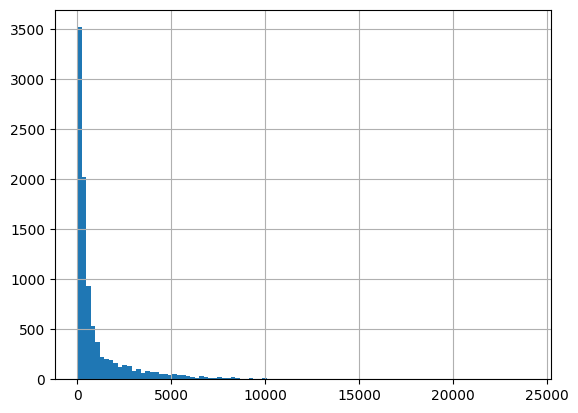


after cleaning



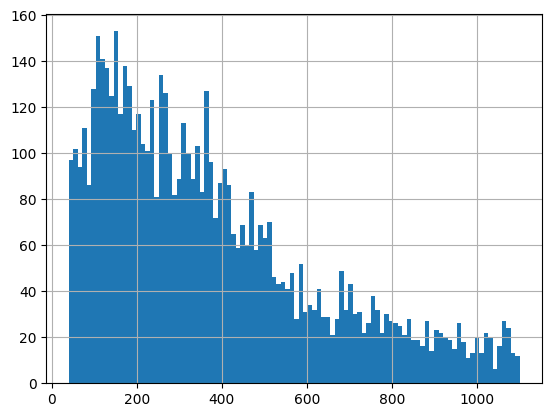

In [ ]:
print('\nbefore cleaning\n')
dg['area'].hist(bins=100)
plt.show()

# config 1
dg = dg[dg['area'] <= 1100]
dg = dg[dg['area'] >= 40]
dg.reset_index(drop=True, inplace=True)

# # config 2
# dg = dg[dg['area']<=900]
# dg = dg[dg['area']>=40]
# dg.reset_index(drop=True, inplace=True)
print('\nafter cleaning\n')
dg['area'].hist(bins=100)
plt.show()

- **Sélection de la racine la plus pertinente**  
  Le code suivant est mis en place pour sélectionner la racine la plus pertinente pour l'entraînement ou l'inférence, selon des critères définis.

- **Critère basé sur les scores des bounding boxes**  
  La pertinence est évaluée à partir des scores des bounding boxes. Étant donné que les bounding boxes finales résultent de la fusion de plusieurs boîtes, on peut utiliser soit le score maximum, soit le score moyen.

- **Critère de surface en cas d'égalité**  
  Si deux racines présentent le même score de bounding box, celle ayant un plus grand nombre de pixels (et donc une surface plus importante) est privilégiée.
- **Exemple d'application**  
  Dans cet exemple, la racine d'index 0 est sélectionnée plutôt que celle d'index 2, conformément aux critères décrits précédemment.


In [ ]:
import ast


def get_best_datas(df):
    max = 0
    index_max = 0
    for index, row in df.iterrows():

        max_row = np.mean(ast.literal_eval(row['scores']))
        row_nbr_points = len(ast.literal_eval(row['points']))

        if max_row > max:
            max = max_row
            index_max = index
            nbr_point = row_nbr_points
        elif max_row == max:
            if row_nbr_points > nbr_point:
                max = max_row
                index_max = index
                nbr_point = row_nbr_points

    return max, index_max


indexs_first = [0, 2]
max, index_max = get_best_datas(
    dg.iloc[indexs_first][['layer', 'scores', 'points']])
print(max, index_max)

0.14318086206912994 0


- **Association des lignes de df et dg**  
  Le code ci-dessous associe chaque ligne du dataframe `df` à une ligne du dataset `dg` en se basant sur le critère de sélection précédemment défini.

- **Vérification de la présence de racines par plante**  
  Chaque ligne de `df` correspond à une plante (index 1 à 7). Si des racines de cette plante sont détectées dans `dg`, l'index correspondant est stocké dans `indexs_first`.

- **Recherche secondaire de correspondance**  
  En l'absence de racine directe, le code vérifie si une autre classification possible de la racine correspond à la plante. Si c'est le cas, l'index est stocké dans `indexs_second`.

- **Gestion des cas ambigus**  
  Si aucune correspondance n'est trouvée, il est supposé que le modèle a pu mal classifier. Le code recherche alors la présence des numéros -1 ou +1 pour la plante dans `dg`, stockant l'index dans `indexs_third`.

- **Traitement final en cas d'absence de racine**  
  Si aucune de ces conditions n'est respectée, on considère que la plante ne possède aucune racine détectée. Celle-ci est alors marquée comme une issue pouvant être supprimée pour l'entraînement ou conservée pour le test, avec une valeur moyenne de `RootVolume` assignée.


In [ ]:
def get_best_masks(df):
    datas = []
    issues = []
    for df_index, df_row in df.iterrows():

        indexs_first = []
        indexs_second = []
        indexs_third = []

        for dg_index, dg_row in dg[dg["name"] == df_row['FolderName']].iterrows():

            dg_plantes = list(map(int, dg_row['plantes'][1:-1].split(', ')))

            if ((df_row['PlantNumber']-1) == dg_plantes[0]):
                indexs_first.append(dg_index)

            if ((df_row['PlantNumber']-1) in dg_plantes[1:]):
                indexs_second.append(dg_index)

            if df_row['PlantNumber']-1 == 0:
                if (1 == dg_plantes[0]):
                    indexs_third.append(dg_index)

            elif df_row['PlantNumber']-1 == 6:
                if (5 == dg_plantes[0]):
                    indexs_third.append(dg_index)

            else:
                before = df_row['PlantNumber']-2
                next = df_row['PlantNumber']
                if before == dg_plantes[0]:
                    indexs_third.append(dg_index)
                if next == dg_plantes[0]:
                    indexs_third.append(dg_index)

        if (not indexs_first) and (not indexs_second):
            if indexs_third:
                print('\nindexs_third : ', df_index)

                max, index_max = get_best_datas(
                    dg.iloc[indexs_third][['layer', 'scores', 'points']])

                datas.append([df_index, index_max])

            else:
                print('\nissue : ', df_index)
                issues.append(df_index)
                datas.append([df_index, 0])
        else:
            if indexs_first:
                max, index_max = get_best_datas(
                    dg.iloc[indexs_first][['layer', 'scores', 'points']])

                datas.append([df_index, index_max])
            else:
                print('\nindexs_second : ', df_index)
                max, index_max = get_best_datas(
                    dg.iloc[indexs_second][['layer', 'scores', 'points']])
                datas.append([df_index, index_max])
    return np.array(datas), issues


datas, issues = get_best_masks(df_train)
df_train_cleaned = df_train.copy()
df_train_cleaned['dg_index'] = datas[:, 1]
df_train_cleaned.drop(index=issues, inplace=True)
print(len(issues))


indexs_third :  0

issue :  1

issue :  8

indexs_second :  12

indexs_third :  14

indexs_third :  16

indexs_second :  19

indexs_third :  24

issue :  28

indexs_second :  31

indexs_second :  35

indexs_second :  41

issue :  46

indexs_second :  48

indexs_third :  63

indexs_second :  65

indexs_third :  67

indexs_second :  69

indexs_third :  77

indexs_second :  81

indexs_third :  82

indexs_third :  84

indexs_third :  86

indexs_third :  92

issue :  99

indexs_second :  100

indexs_third :  101

indexs_third :  105

issue :  110

indexs_third :  112

indexs_third :  113

indexs_second :  120

indexs_third :  121

issue :  131

indexs_second :  132

indexs_third :  134

indexs_second :  137

indexs_third :  142

issue :  143

indexs_third :  146

indexs_second :  149

indexs_third :  151

indexs_third :  160

indexs_third :  161

indexs_third :  166

indexs_third :  169

indexs_third :  171

indexs_third :  178

indexs_third :  182

indexs_third :  184

indexs_second :  18

Le code suivant sert juste a vérifier quelle racine a été associée à quelle plante.


score : 0.20, index : 1724, plante g : [3], plante f : 2 


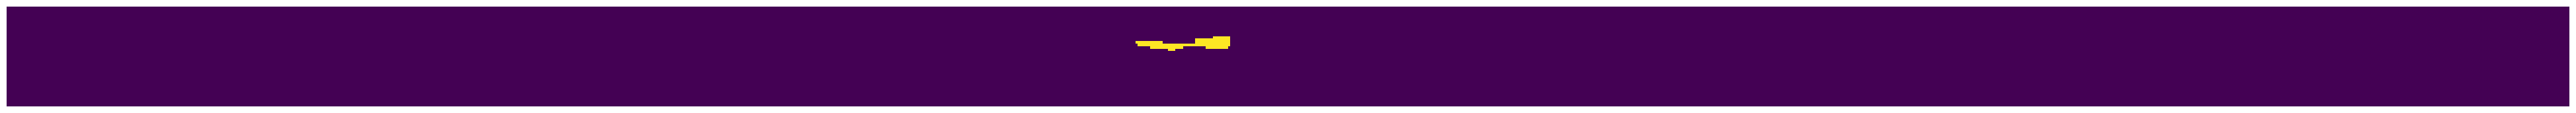

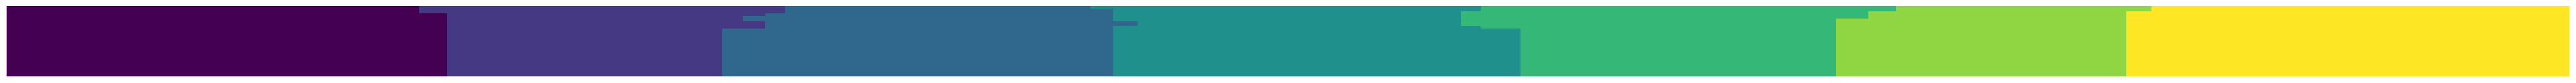

score : 0.19, index : 1529, plante g : [3], plante f : 3 


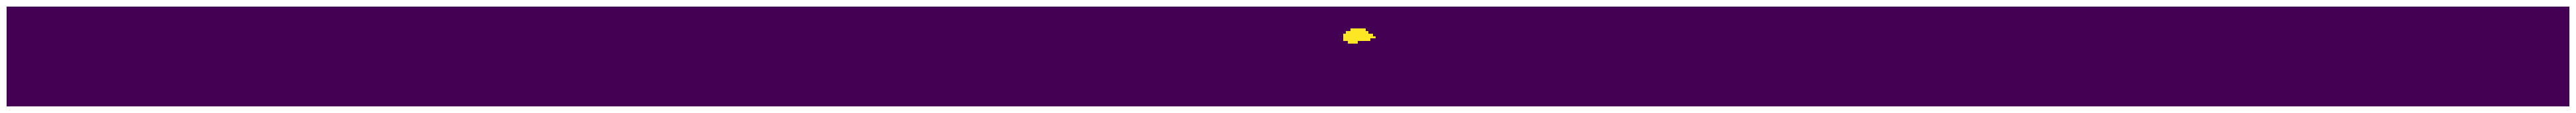

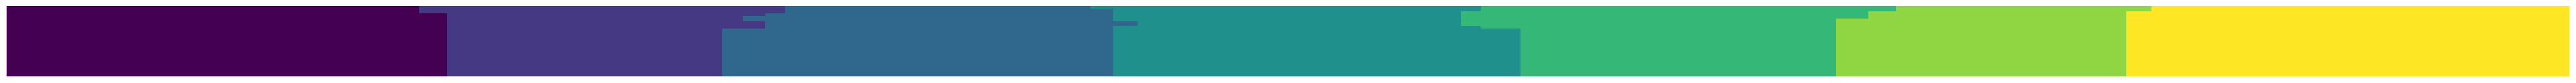

score : 0.14, index : 2968, plante g : [5, 4], plante f : 5 


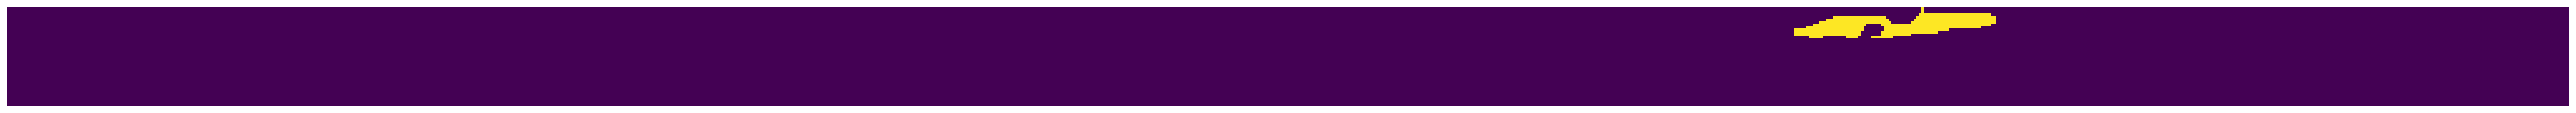

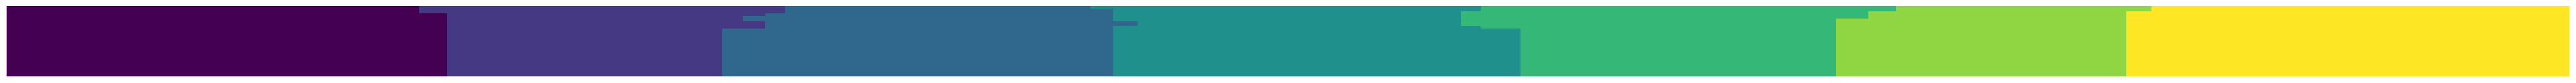

score : 0.26, index : 827, plante g : [6], plante f : 6 


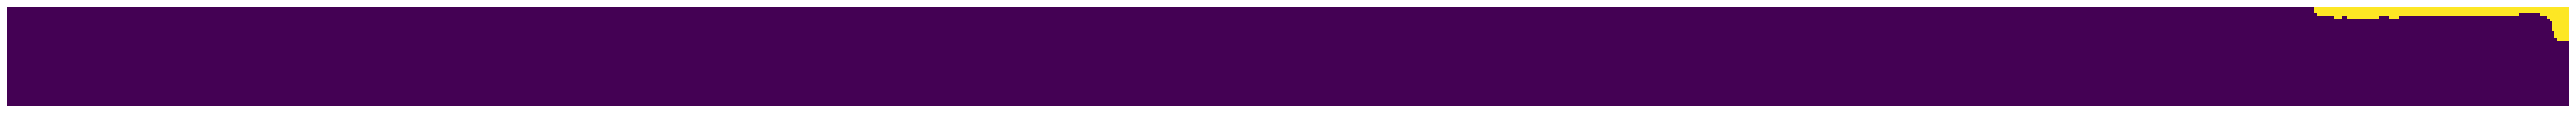

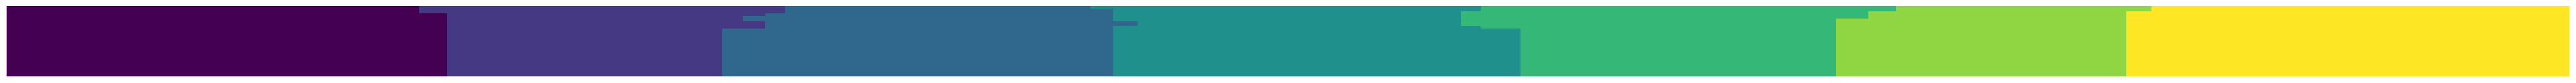

score : 0.27, index : 3458, plante g : [3], plante f : 3 


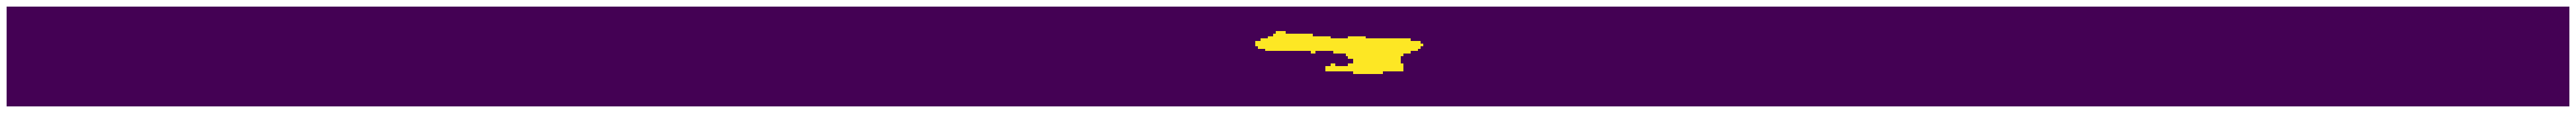

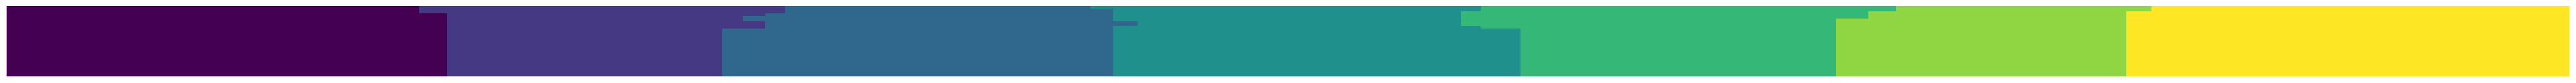

score : 0.43, index : 3026, plante g : [2], plante f : 2 


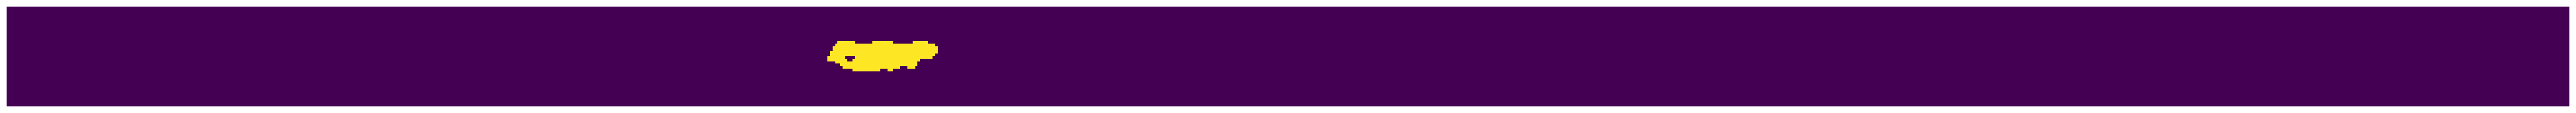

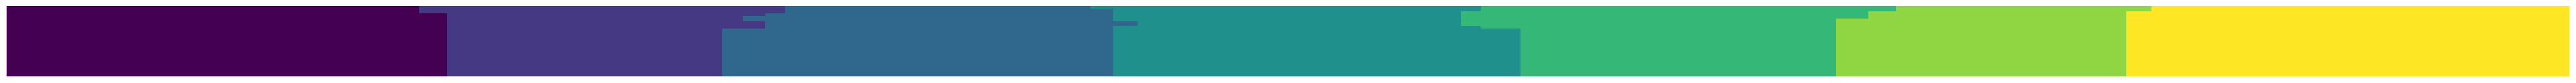

score : 0.46, index : 1915, plante g : [1, 0], plante f : 1 


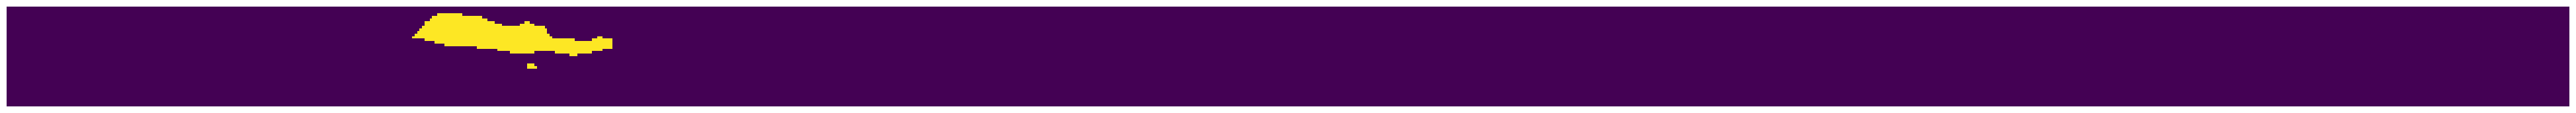

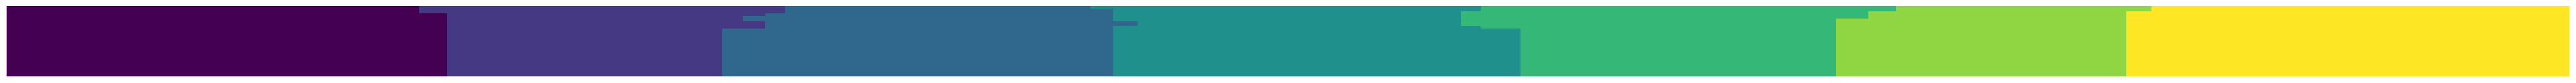

score : 0.41, index : 3599, plante g : [4], plante f : 4 


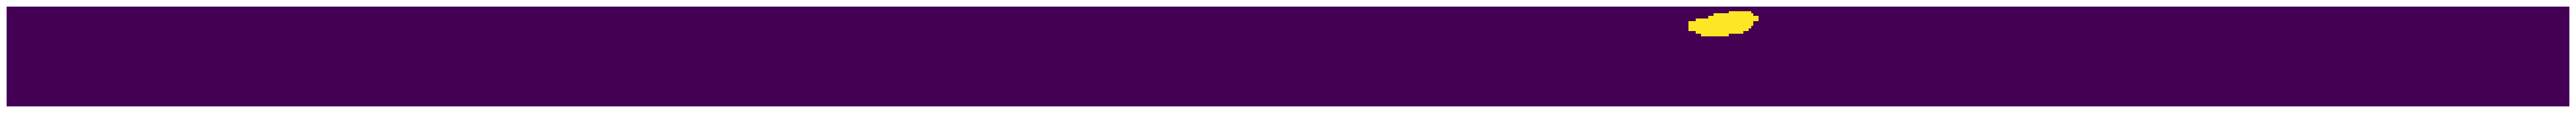

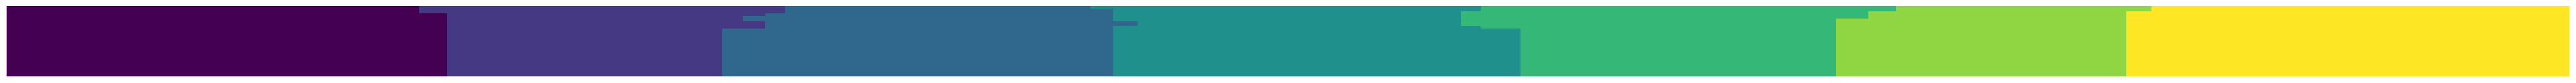

score : 0.78, index : 1369, plante g : [3, 4], plante f : 3 


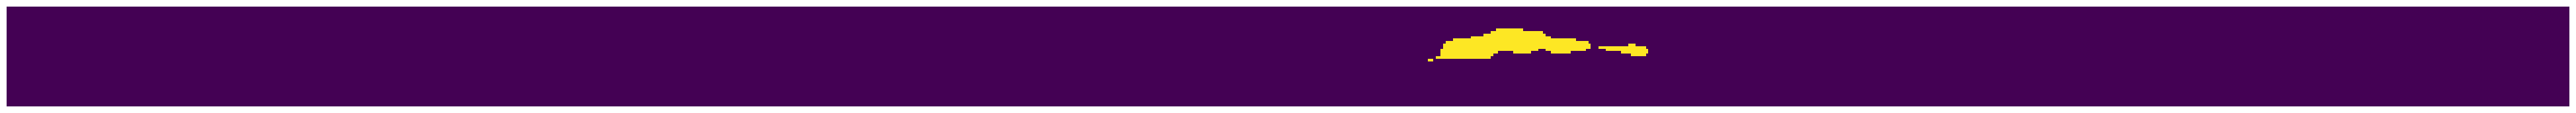

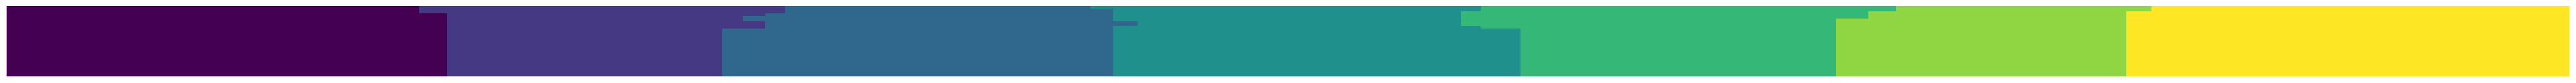

score : 0.33, index : 576, plante g : [3, 2], plante f : 3 


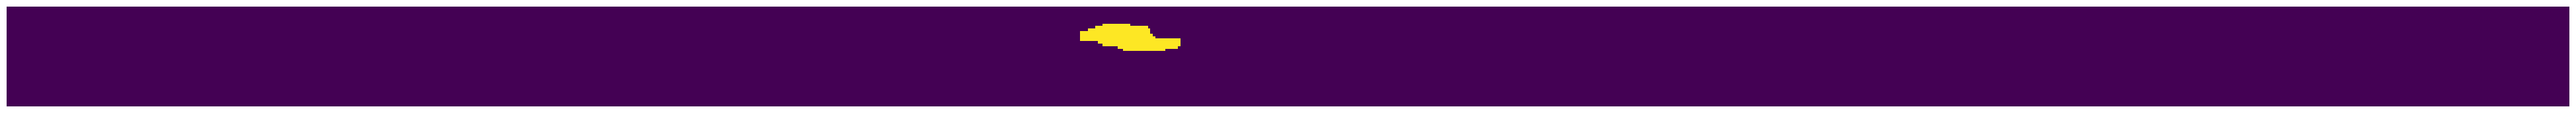

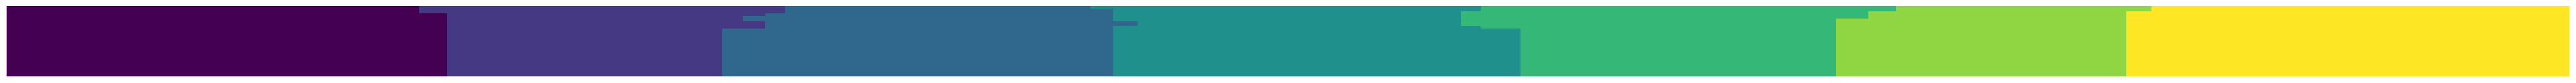

In [ ]:
early_stop = 0
for (index, ele), df_index in zip(dg.iloc[df_train_cleaned['dg_index']].iterrows(), df_train_cleaned.index):

    points = ele['points']
    points = np.array(ast.literal_eval(points))

    scores = np.mean(ast.literal_eval(ele['scores']))
    img = np.zeros((40, 1024)).astype(np.uint8)
    img[points[:, 0], points[:, 1]] = 255
    plante_f = df_train_cleaned['PlantNumber'][df_index]-1

    print(
        f'score : {scores:.2f}, index : {index}, plante g : {ele["plantes"]}, plante f : {plante_f} ')
    display_image(img)
    display_image(segmented_image)
    early_stop+=1
    if early_stop==10:
      break

- **Importation et préparation des données**  
  Importation des bibliothèques (LightGBM, scikit-learn, pandas). Extraction des features (`area`, `perimeter`, `skeleton_length`, `mean_diameter`) à partir de `dg` (indexé via `df_train_cleaned['dg_index']`) et définition de la cible `RootVolume` depuis `df_train_cleaned`.

- **Séparation en ensembles d'entraînement et de validation**  
  Division des données en 80% pour l'entraînement et 20% pour la validation avec `train_test_split` pour garantir une évaluation fiable.

- **Création des datasets LightGBM**  
  Transformation des ensembles d'entraînement et de validation en objets `lgb.Dataset`, requis par LightGBM pour l'entraînement.

- **Paramétrage et entraînement du modèle**  
  Définition des paramètres du modèle de régression (objectif, métrique MSE, learning_rate, num_leaves, max_depth, etc.). Entraînement avec un maximum de 10 000 itérations, intégrant l'arrêt anticipé (early stopping après 50 itérations sans amélioration) et affichage périodique des logs.

- **Prédiction et évaluation**  
  Prédiction sur l'ensemble de validation pour calculer le MSE. Application du modèle sur tout le DataFrame `dg` pour prédire `RootVolume` et ajout des prédictions dans une nouvelle colonne.


Training until validation scores don't improve for 50 rounds
[50]	train's l2: 2.3189	val's l2: 1.05061
[100]	train's l2: 2.13362	val's l2: 1.01067
[150]	train's l2: 2.00426	val's l2: 0.988621
[200]	train's l2: 1.91005	val's l2: 0.971609
[250]	train's l2: 1.84459	val's l2: 0.961035
[300]	train's l2: 1.78317	val's l2: 0.954524
[350]	train's l2: 1.71409	val's l2: 0.951631
[400]	train's l2: 1.64474	val's l2: 0.941621
[450]	train's l2: 1.59327	val's l2: 0.93201
[500]	train's l2: 1.54596	val's l2: 0.923528
[550]	train's l2: 1.49983	val's l2: 0.929311
Early stopping, best iteration is:
[514]	train's l2: 1.52945	val's l2: 0.921718
Validation MSE: 0.9217176025044234


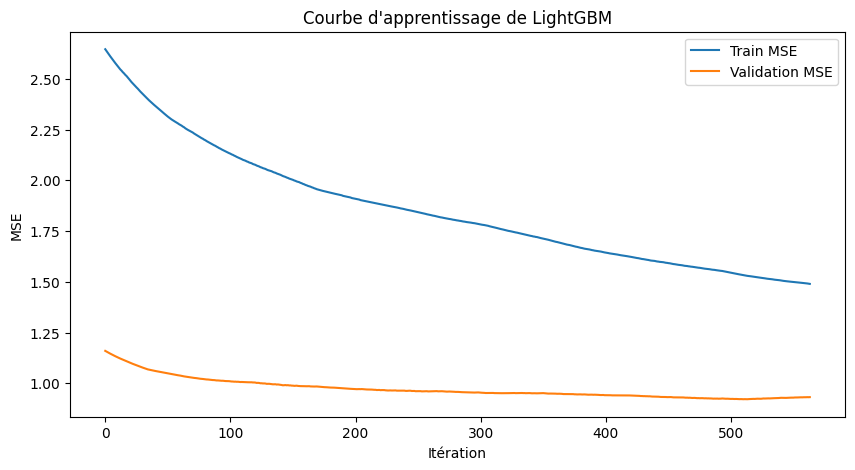

In [ ]:
import lightgbm as lgb
from lightgbm import record_evaluation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt


X = dg.iloc[df_train_cleaned['dg_index']][[
    'area', 'perimeter', 'skeleton_length', 'mean_diameter']]
y = df_train_cleaned['RootVolume']


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

d_train = lgb.Dataset(X_train, label=y_train)
d_val = lgb.Dataset(X_val, label=y_val)

params = {
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate': 0.0073,
    'num_leaves': 200,
    'max_depth': 4,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 0,
    'verbose': -1
}


evals_result = {}
callbacks = [
    record_evaluation(evals_result),
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(50)
]

model = lgb.train(
    params,
    d_train,
    num_boost_round=3000,
    valid_sets=[d_train, d_val],
    valid_names=['train', 'val'],
    callbacks=callbacks
)

y_pred = model.predict(X_val, num_iteration=model.best_iteration)
mse = mean_squared_error(y_val, y_pred)
dg['RootVolume'] = model.predict(
    dg[['area', 'perimeter', 'skeleton_length', 'mean_diameter']], num_iteration=model.best_iteration)
print("Validation MSE:", mse)

plt.figure(figsize=(10, 5))
plt.plot(evals_result['train']['l2'], label='Train MSE')
plt.plot(evals_result['val']['l2'], label='Validation MSE')
plt.xlabel('Itération')
plt.ylabel('MSE')
plt.title("Courbe d'apprentissage de LightGBM")
plt.legend()
plt.show()

In [ ]:
datas, issues = get_best_masks(df_test)
df_test_cleaned = df_test.copy()
df_test_cleaned['dg_index'] = datas[:, 1]


indexs_third :  5

indexs_third :  6

indexs_third :  14

indexs_third :  16

issue :  23

issue :  27

indexs_second :  33

indexs_second :  34

indexs_third :  39

indexs_second :  43

indexs_third :  46

indexs_second :  55

indexs_third :  56

issue :  57

indexs_third :  61

indexs_second :  72

indexs_second :  74

indexs_second :  76

indexs_third :  77

indexs_third :  85

issue :  89

indexs_third :  97

indexs_third :  100

indexs_third :  105

indexs_third :  109

indexs_second :  115


- **Gestion des valeurs problématiques**  
  Certaines plantes présentent des issues. Pour pallier ce problème, nous attribuons à ces plantes la valeur moyenne des poids des racines calculée sur le jeu de test. Le code ci-dessous permet de générer le dataset de soumission pour évaluer les résultats.


In [ ]:
df_test_cleaned['RootVolume'] = 0.

for df_index, row in df_test_cleaned.iterrows():
    dg_index = row['dg_index']
    if df_index not in issues:
        df_test_cleaned.loc[df_index,
                            'RootVolume'] = dg.loc[dg_index, 'RootVolume']

mean = dg[dg['train'] == 0]['RootVolume'].mean()
df_test_cleaned.loc[issues, 'RootVolume'] = mean
if (df_test_cleaned['RootVolume'] <= 0).mean() == 0.0:
    print('no missing values')
    df_test_cleaned[['ID', 'RootVolume']].to_csv(
        'submission.csv', index=False, sep=',')
else:
    print('error')

no missing values


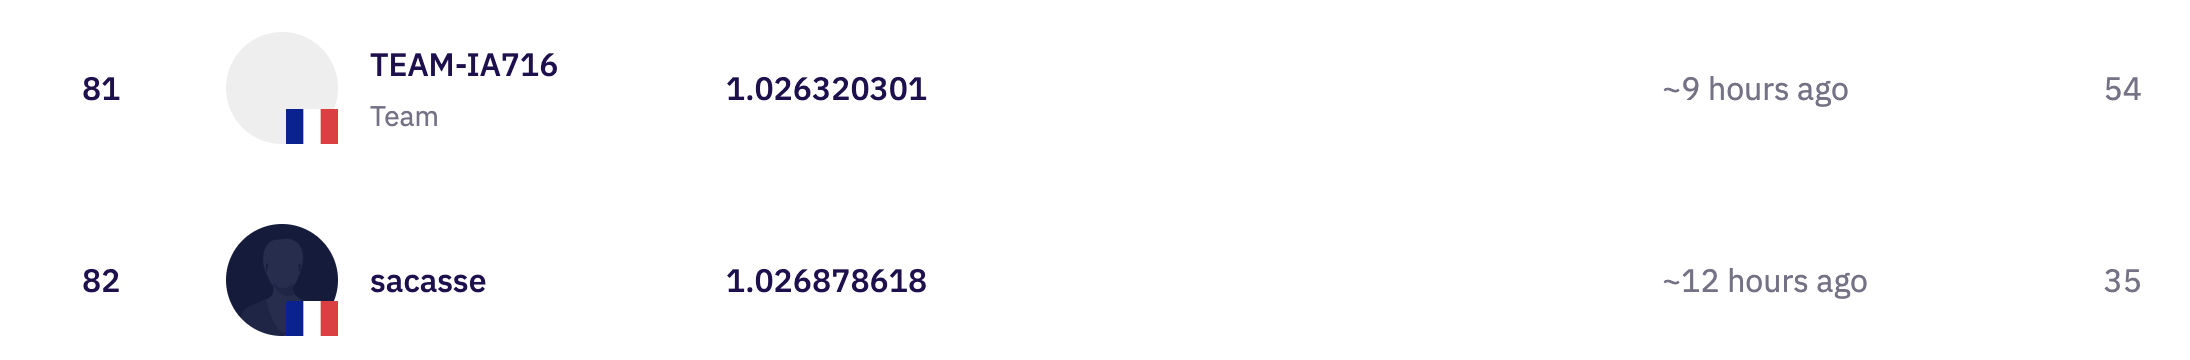


Nous constatons que les approches 2 et 3 (qui utilisent un deuxième compte pour augmenter le nombre de soumissions) donnent des résultats quasiment identiques. Une méthode basée sur un choix de racine optimisé pourrait potentiellement surpasser l'approche 2, et nous explorons actuellement cette piste. Il nous reste encore 6 jours avant la fin du projet, ce qui nous laisse le temps de tester cette solution.


## Conclusion

Ce challenge Zindi a représenté une excellente opportunité pour mettre en pratique les connaissances acquises en computer vision, en nous confrontant à un problème concret et compétitif. Notre objectif était d'estimer le volume des racines de manioc à partir d'images générées par un radar à pénétration de sol, en combinant des techniques de segmentation d'images et d'apprentissage automatique.

Malgré plusieurs difficultés techniques rencontrées au cours du projet, nous avons su les surmonter en affinant progressivement notre approche. Parmi les défis majeurs, nous avons dû gérer le format spécifique des données **(6,244,244)**, optimiser le prétraitement des images pour améliorer leur exploitabilité et sélectionner les modèles les plus pertinents pour l'analyse. Nous avons également dû expérimenter différentes architectures, optimiser l'entraînement sur GPU et ajuster les hyperparamètres afin d'obtenir des résultats compétitifs.

Grâce à ces efforts, nous avons réussi à atteindre une **RMSE de 1.02** sur les données de test fournies par Zindi, un score qui se rapproche du meilleur obtenu dans la compétition **(0.78)**. Ce résultat nous a permis de nous classer **80ᵉ sur 984 participants**, ce qui démontre la solidité de notre approche et notre capacité à développer des solutions performantes dans un cadre compétitif.

Cependant, nous ne comptons pas nous arrêter là. Le challenge étant encore en cours jusqu'au **9**, nous continuons à travailler activement pour améliorer notre modèle et affiner nos résultats. Parmi les axes d'amélioration, nous envisageons :

- **L'amélioration des stratégies de prétraitement des images** pour mieux exploiter les données fournies.
- **L'affinement de la sélection des plages d'images optimales**, ce qui pourrait réduire le bruit et améliorer la précision des prédictions.
- **L'exploration d'architectures de réseaux de neurones plus adaptées**, notamment avec des modèles de segmentation plus avancés comme **YOLO v11**.
- **L'optimisation de l'entraînement** en testant différentes stratégies de régularisation et d'augmentation des données.

En conclusion, cette compétition nous a permis de consolider nos compétences en **computer vision** et d’appliquer nos connaissances à un problème réel tout en nous confrontant aux exigences d'un défi compétitif. Nous sommes fiers du chemin parcouru et restons déterminés à améliorer notre score d'ici la clôture du challenge. Ce projet constitue une expérience enrichissante qui nous servira pour nos futurs travaux en intelligence artificielle et en vision par ordinateur.


### Classement final zindi:

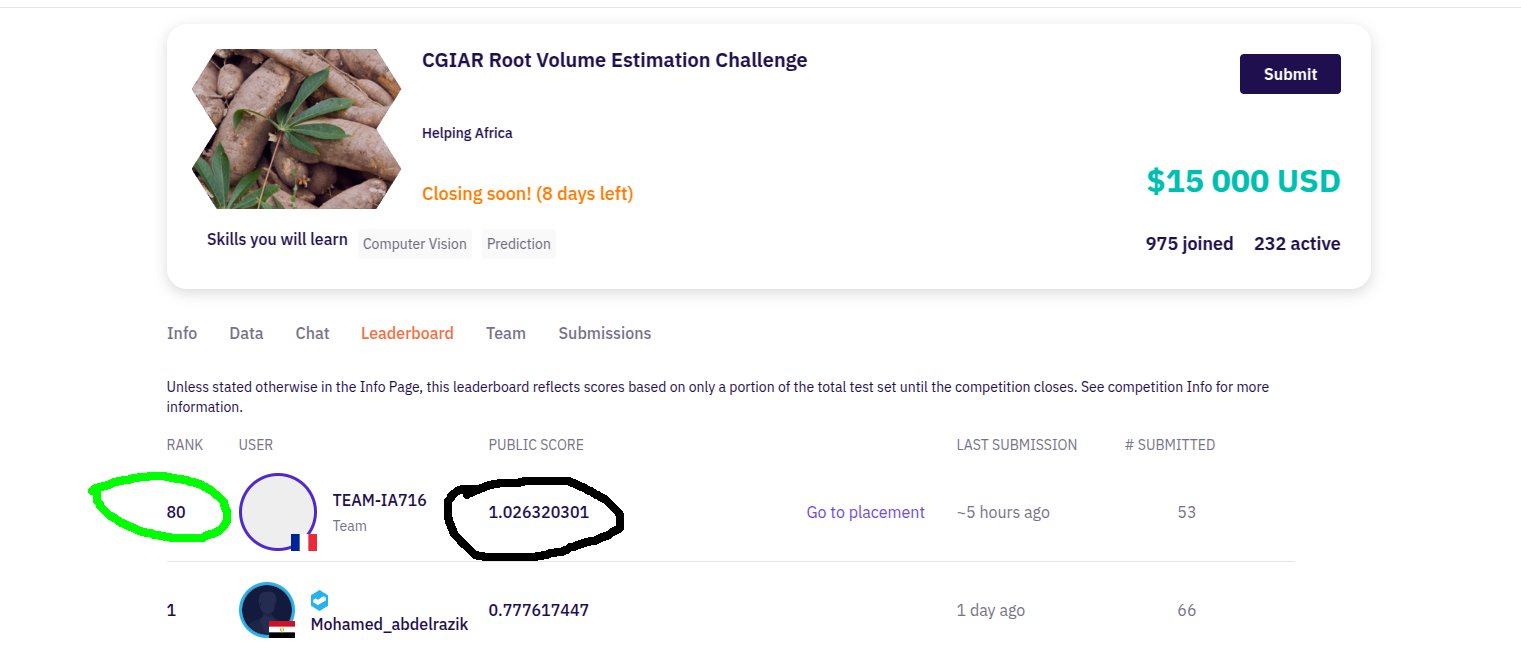


#**References**

[1] **Juan Terven, Diana Cordova-Esparza** (2023) A Comprehensive Review of YOLO Architectures in Computer Vision: From YOLOv1 to YOLOv8 and YOLO-NAS https://arxiv.org/pdf/2304.00501

[2] **Hey Amit** (2024) Building ResNet18 from Scratch Using PyTorch https://medium.com/biased-algorithms/building-resnet18-from-scratch-using-pytorch-64c6619432f2

[3] **Rothi Gandhi** (2018) R-CNN, Fast R-CNN, Faster R-CNN, YOLO — Object Detection Algorithms https://medium.com/towards-data-science/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e

[4] **Jun Yuan Bingbing NI Ashraf A.KASSIM** Half-CNN: A General Framework for Whole-Image Regression https://arxiv.org/pdf/1412.6885

[5] **Khuyen Le** (2021) A quick overview of ResNet models https://lekhuyen.medium.com/a-quick-overview-of-resnet-models-f8ed277ae81e

[6] **Kirillov, Alexander et al.** (2023) Segment Anything. Proceedings of the IEEE/CVF International Conference on Computer Vision, pp. 4015–4026. https://arxiv.org/abs/2304.02643
